## Load Dependencies

In [ ]:
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

## Load Data

In [ ]:
NUMBER_OF_PICTURES = 1818 # Total number of images in the dataset
SIZE=200 # Change image size if needed
DATASET = 'dataset2.0' # Change this to the path of dataset image folder if needed
DATASET_EXCEL = 'dataset_2.0.xlsx' # Change this to the path of dataset excel file if needed

In [ ]:
def img_to_array(img):
    return np.asarray(img)

clean_data=[]
path = DATASET
files=os.listdir(path)
for i in tqdm(files):
    img=cv2.imread(path+'/'+i)  #Change 0 to 1 for color images
    # print(path+'/'+i)
    if(img.shape[0] > 0):
        img=cv2.resize(img,(SIZE, SIZE))
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        clean_data.append(img_to_array(img))
    else:
        print(img.shape)
        print(i)
        print(path+'/'+i)


100%|██████████| 1818/1818 [07:42<00:00,  3.93it/s]


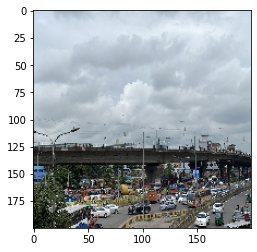

In [5]:
clean_data=clean_data[:NUMBER_OF_PICTURES]
plt.imshow(clean_data[0],cmap='binary')
new_clean=[]
for i in clean_data:
    i=i/255
    new_clean.append(i)

In [6]:
for i in new_clean:
    x=i
    x[x<0.5]=0

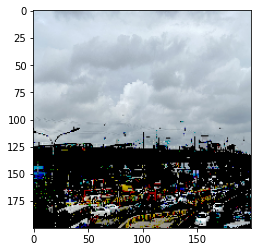

In [7]:
plt.imshow(new_clean[0],cmap='binary')

## Data analysis - Removing the noise

In [10]:
arr_ind =  np.arange(NUMBER_OF_PICTURES)
mean_row=[]
for i in arr_ind:
    mean_row.append(np.mean(new_clean[i][120]))
mean_array=np.array(mean_row)

## Check if most of the information are inside this range 

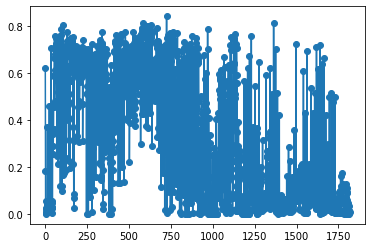

In [11]:
plt.scatter(arr_ind,mean_array)
plt.plot(arr_ind,mean_array)
plt.show()

## Cropping the images - only keeping the sky portion

In [12]:
for i in range(len(new_clean)):
    new_clean[i]=new_clean[i][:120]

In [ ]:
df=pd.read_excel(DATASET_EXCEL, engine='openpyxl').head(NUMBER_OF_PICTURES)

In [14]:
# print(df)
df.isnull().any()

Image no.            False
Date                 False
Time                 False
DATE & TIME           True
Place                False
NowCastConc. Unit     True
PM2.5                False
AQI Category          True
Raw Conc.             True
Conc. Unit           False
Remarks               True
Unnamed: 11           True
Unnamed: 12           True
Unnamed: 13           True
dtype: bool

In [4]:
y=df['PM2.5']
y=np.asarray(y).astype('float32')
print(len(y))
print(type(y))
print(y)

1818
<class 'numpy.ndarray'>
[103. 103.  84. ... 163. 163. 171.]


## Data Distribution

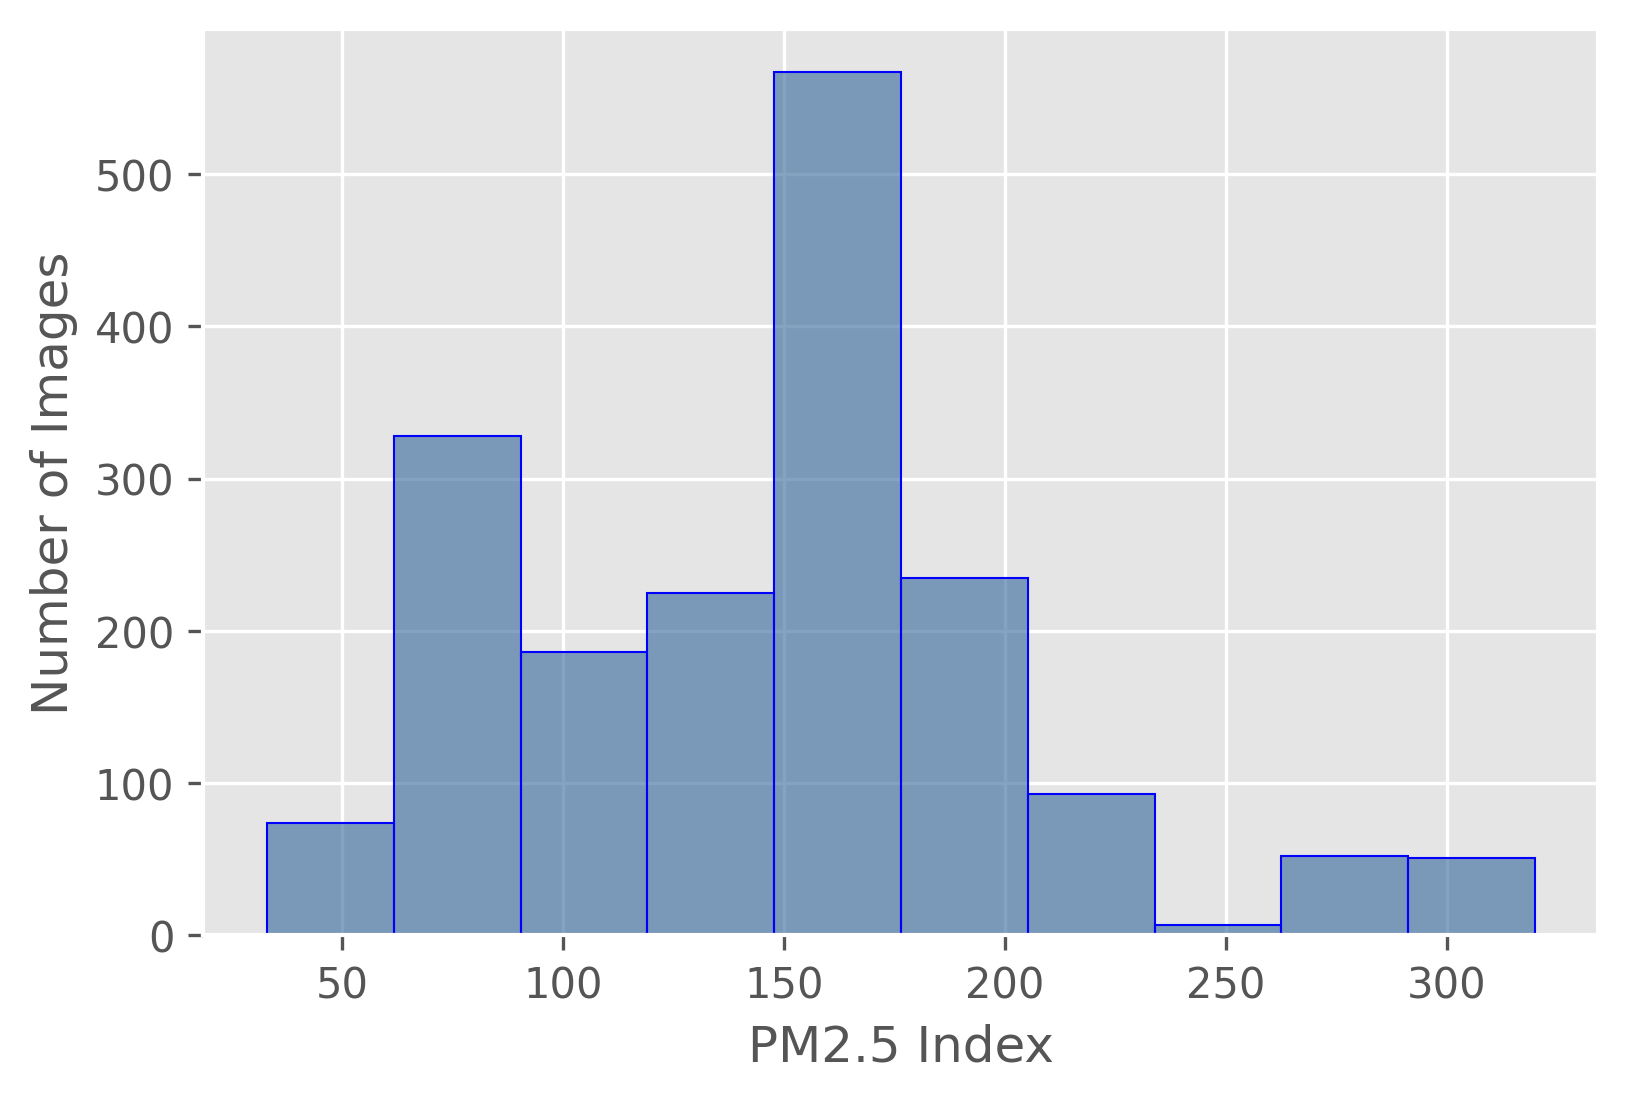

In [18]:
y = df['PM2.5']
y = np.array(y)


check_0_50 = 0 
check_50_100 = 0
check_100_150 = 0
check_150_200 = 0
check_200_250 = 0
check_250_300 = 0
check_300_more = 0  

j = 0
for i in y:
    j = j + 1
    if i < 50:
        check_0_50 = check_0_50 + 1
    elif i >= 50 and i<100:
        # print(j-1)
        check_50_100 = check_50_100 + 1
    elif i >= 100 and i<150:
        # print(j-1)
        check_100_150 = check_100_150 + 1
    elif i >= 150 and i<200:
        # print(j-1)
        check_150_200 = check_150_200 + 1
    elif i >= 200 and i<250:
        # print(j-1)
        check_250_300 = check_250_300 + 1
    elif i >= 250 and i<300:
        # print(j-1)
        check_50_100 = check_50_100 + 1
    elif i >= 300:
        # print(j-1)
        check_300_more = check_300_more + 1

arr = [check_0_50, check_50_100, check_100_150, check_150_200, check_200_250, check_250_300, check_300_more]
z = [0, 50, 100, 150, 200, 250, 300]

# plt.style.use('ggplot')
# plt.bar(x=np.arange(y.size),height=y)
plt.hist(y, color=(0.2, 0.4, 0.6, 0.6),  edgecolor='blue')
plt.xlabel('PM2.5 Index')
plt.ylabel('Number of Images')
plt.gcf().set_dpi(300)
# plt.grid()
plt.show()

In [18]:
new_clean[0].shape

(120, 200, 3)

In [ ]:
X=new_clean
print(len(X))
X=np.asarray(X).astype('float32')

print(type(X))

1818
<class 'numpy.ndarray'>


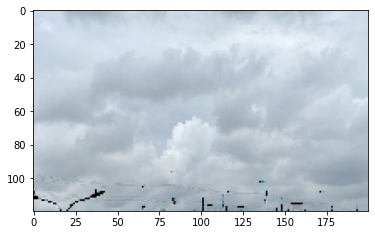

In [ ]:
plt.imshow(new_clean[0],cmap='binary')

## Dataset Splitting

In [ ]:
TEST_SIZE = 0.10 # Change test size if needed
SEED = 42 # Change random seed if needed

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = TEST_SIZE, random_state = SEED,shuffle=True)

In [22]:
x_train = x_train.reshape(-1,120,200, 3)

x_test = x_test.reshape(-1,120,200, 3)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1636, 120, 200, 3)
(182, 120, 200, 3)
(1636,)
(182,)


## Model Development

In [ ]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.ZeroPadding2D(padding=(3, 3), input_shape=(120,200,3)),
    # First Conv2d Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Second Conv2d Block
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2), 
    # Third Conv2d Block
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Fourth Conv2d Block
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Fifth and Final Conv2d Block
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # Fully Connected Layer
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1,activation='linear')  
])


## Model Summary

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 126, 206, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 204, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 204, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 202, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 122, 202, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 101, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 99, 128)       7

## Visualize the Model

In [27]:
# from PIL import ImageFont
# from collections import defaultdict

# font = ImageFont.truetype("arial.ttf", 18) 

# color_map = defaultdict(dict)
# color_map[tf.keras.layers.Conv2D]['fill'] = 'orange'
# color_map[tf.keras.layers.Dropout]['fill'] = 'silver'
# color_map[tf.keras.layers.MaxPooling2D]['fill'] = 'red'
# color_map[tf.keras.layers.Dense]['fill'] = 'blue'
# color_map[tf.keras.layers.Flatten]['fill'] = 'purple'
# color_map[tf.keras.layers.BatchNormalization]['fill'] = 'lightgreen'

# import visualkeras
# visualkeras.layered_view(model, legend=True,font=font,color_map=color_map)#, draw_volume=False)

## Images with Unique Values

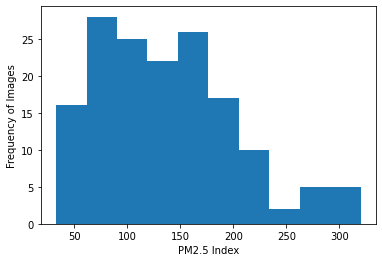

In [ ]:
y = df['PM2.5']
y = np.array(y)

unique, counts = np.unique(y, return_counts=True)

xpoints = np.array(unique)
ypoints = np.array(counts)

plt.hist(xpoints)
plt.xlabel('PM2.5 Index')
plt.ylabel('Frequency of Images')
plt.gcf().set_dpi(300)
plt.show()

## Model Compilation

In [ ]:
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers import RMSprop

LR = 0.000001 # Change learning rate if needed

optimum=Adam(learning_rate=LR)
model.compile(optimizer=optimum, loss='mean_absolute_error',metrics=['mean_squared_error',tf.keras.metrics.RootMeanSquaredError()])

## Fitting The Model

In [ ]:
import time

BATCH_SIZE = 8 # Change batch size if needed
EPOCHS = 350 # Change number of epochs if needed
VALIDATION_SPLIT = 0.1 # Change validation split if needed

start = time.process_time()
hist = model.fit(x_train, y_train, 
           batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)
print(time.process_time() - start)

Epoch 1/350
184/184 [==============================] - 15s 34ms/step - loss: 138.9648 - mean_squared_error: 22792.1191 - root_mean_squared_error: 150.9706 - val_loss: 154.3351 - val_mean_squared_error: 27484.3027 - val_root_mean_squared_error: 165.7839
Epoch 2/350
184/184 [==============================] - 5s 29ms/step - loss: 124.2202 - mean_squared_error: 19430.4355 - root_mean_squared_error: 139.3931 - val_loss: 146.0532 - val_mean_squared_error: 25223.4609 - val_root_mean_squared_error: 158.8190
Epoch 3/350
184/184 [==============================] - 5s 29ms/step - loss: 106.6257 - mean_squared_error: 15925.3291 - root_mean_squared_error: 126.1956 - val_loss: 123.8781 - val_mean_squared_error: 19872.1211 - val_root_mean_squared_error: 140.9685
Epoch 4/350
184/184 [==============================] - 5s 29ms/step - loss: 91.8269 - mean_squared_error: 12662.4385 - root_mean_squared_error: 112.5275 - val_loss: 100.8237 - val_mean_squared_error: 14635.0576 - val_root_mean_squared_error: 1

## Print Predicted values

In [31]:
predictions = model.predict([x_test])
pred=[]
for i in predictions:
    print(int(i[0]))
    pred.append(int(i[0]))

116
174
129
109
200
108
183
161
125
115
176
181
191
118
226
169
155
125
184
173
194
115
96
126
121
112
171
153
157
159
111
84
182
164
120
166
172
119
134
162
180
119
159
109
156
94
85
208
160
116
81
222
164
131
86
96
127
141
146
193
138
127
126
146
140
146
90
169
139
136
77
160
178
179
204
122
99
130
138
183
153
141
114
152
171
196
112
162
189
135
84
155
82
154
147
170
87
194
143
80
94
165
173
146
93
185
103
148
177
181
113
168
162
130
98
124
170
172
109
160
139
109
188
106
147
170
195
149
92
192
183
114
212
85
60
234
141
81
121
163
169
145
97
198
170
172
162
135
196
148
120
180
106
150
151
105
140
179
124
135
95
184
158
168
177
158
130
125
167
196
151
160
144
156
149
85
169
160
135
182
152
143


## Print True Values

In [32]:
for i in y_test:
    print(i)

101.0
182.0
89.0
294.0
162.0
90.0
145.0
168.0
136.0
143.0
171.0
107.0
186.0
143.0
165.0
89.0
287.0
81.0
266.0
296.0
165.0
108.0
101.0
134.0
119.0
98.0
155.0
230.0
143.0
168.0
56.0
81.0
196.0
162.0
81.0
196.0
208.0
102.0
135.0
204.0
207.0
140.0
171.0
93.0
207.0
101.0
82.0
136.0
183.0
143.0
76.0
201.0
166.0
159.0
64.0
97.0
159.0
128.0
144.0
278.0
81.0
143.0
120.0
163.0
155.0
143.0
93.0
161.0
216.0
143.0
74.0
178.0
178.0
170.0
296.0
120.0
125.0
157.0
87.0
201.0
165.0
157.0
143.0
115.0
174.0
275.0
124.0
201.0
201.0
171.0
67.0
128.0
76.0
153.0
95.0
251.0
76.0
171.0
128.0
71.0
130.0
164.0
174.0
156.0
88.0
108.0
57.0
164.0
170.0
232.0
80.0
162.0
201.0
183.0
67.0
156.0
162.0
202.0
68.0
175.0
101.0
59.0
162.0
76.0
112.0
164.0
296.0
196.0
76.0
171.0
278.0
184.0
170.0
114.0
66.0
207.0
162.0
64.0
143.0
183.0
208.0
158.0
156.0
232.0
158.0
173.0
164.0
173.0
168.0
168.0
158.0
65.0
95.0
296.0
154.0
92.0
143.0
136.0
61.0
140.0
80.0
168.0
166.0
156.0
76.0
161.0
136.0
135.0
104.0
207.0
208.0
198.0
144.0


## Mean Difference from the true value

In [33]:
diff=[]
for i in range(len(pred)):
    diff.append(abs(y_test[i]-pred[i]))
print(sum(diff) / len(diff))

29.692307692307693


## Print Differences

In [34]:
for i in diff:
    print(i)

15.0
8.0
40.0
185.0
38.0
18.0
38.0
7.0
11.0
28.0
5.0
74.0
5.0
25.0
61.0
80.0
132.0
44.0
82.0
123.0
29.0
7.0
5.0
8.0
2.0
14.0
16.0
77.0
14.0
9.0
55.0
3.0
14.0
2.0
39.0
30.0
36.0
17.0
1.0
42.0
27.0
21.0
12.0
16.0
51.0
7.0
3.0
72.0
23.0
27.0
5.0
21.0
2.0
28.0
22.0
1.0
32.0
13.0
2.0
85.0
57.0
16.0
6.0
17.0
15.0
3.0
3.0
8.0
77.0
7.0
3.0
18.0
0.0
9.0
92.0
2.0
26.0
27.0
51.0
18.0
12.0
16.0
29.0
37.0
3.0
79.0
12.0
39.0
12.0
36.0
17.0
27.0
6.0
1.0
52.0
81.0
11.0
23.0
15.0
9.0
36.0
1.0
1.0
10.0
5.0
77.0
46.0
16.0
7.0
51.0
33.0
6.0
39.0
53.0
31.0
32.0
8.0
30.0
41.0
15.0
38.0
50.0
26.0
30.0
35.0
6.0
101.0
47.0
16.0
21.0
95.0
70.0
42.0
29.0
6.0
27.0
21.0
17.0
22.0
20.0
39.0
13.0
59.0
34.0
12.0
1.0
2.0
38.0
28.0
20.0
38.0
115.0
11.0
146.0
3.0
13.0
3.0
43.0
63.0
5.0
15.0
16.0
8.0
12.0
101.0
3.0
6.0
10.0
63.0
11.0
57.0
38.0
0.0
22.0
32.0
85.0
15.0
18.0
28.0
9.0
31.0
0.0


### Test Values

In [35]:
eva = model.evaluate(x_test, y_test)
print(eva)

6/6 [==============================] - 0s 22ms/step - loss: 29.6781 - mean_squared_error: 1782.0818 - root_mean_squared_error: 42.2147
[29.678131103515625, 1782.081787109375, 42.2147102355957]


### MSE Train vs Validation Curve

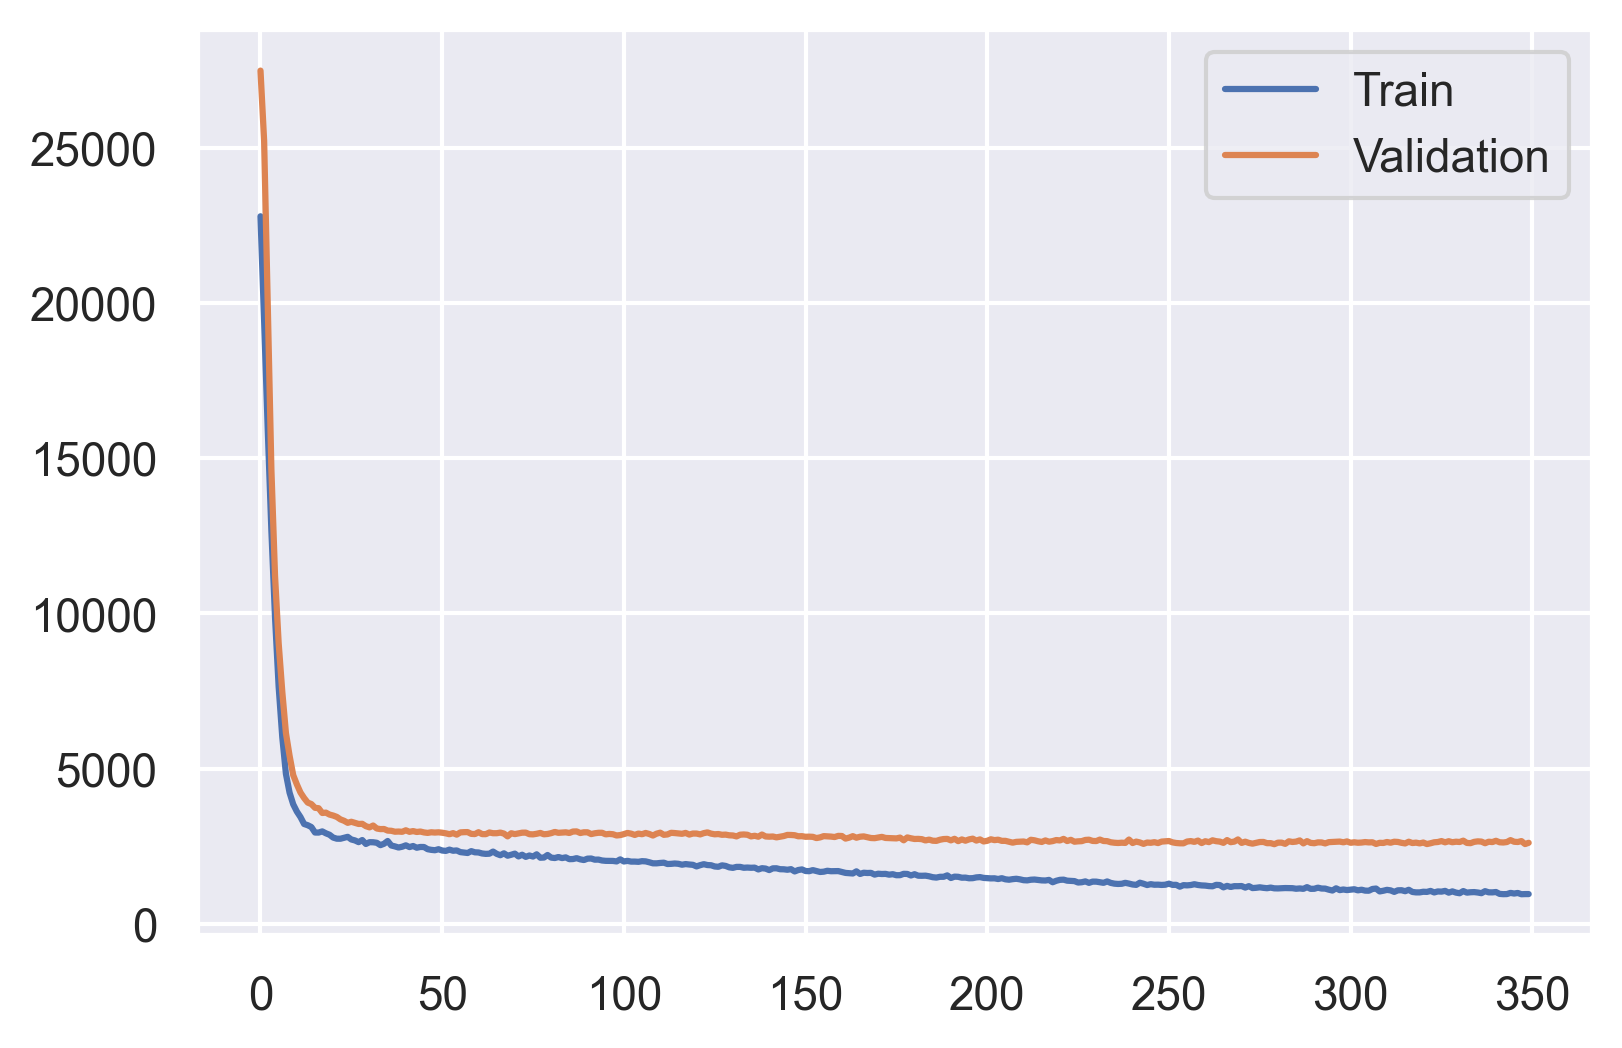

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.set()

plt.plot(hist.history['mean_squared_error'], label='Train')
plt.plot(hist.history['val_mean_squared_error'], label='Validation')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


### MAE Train vs Validation Curve

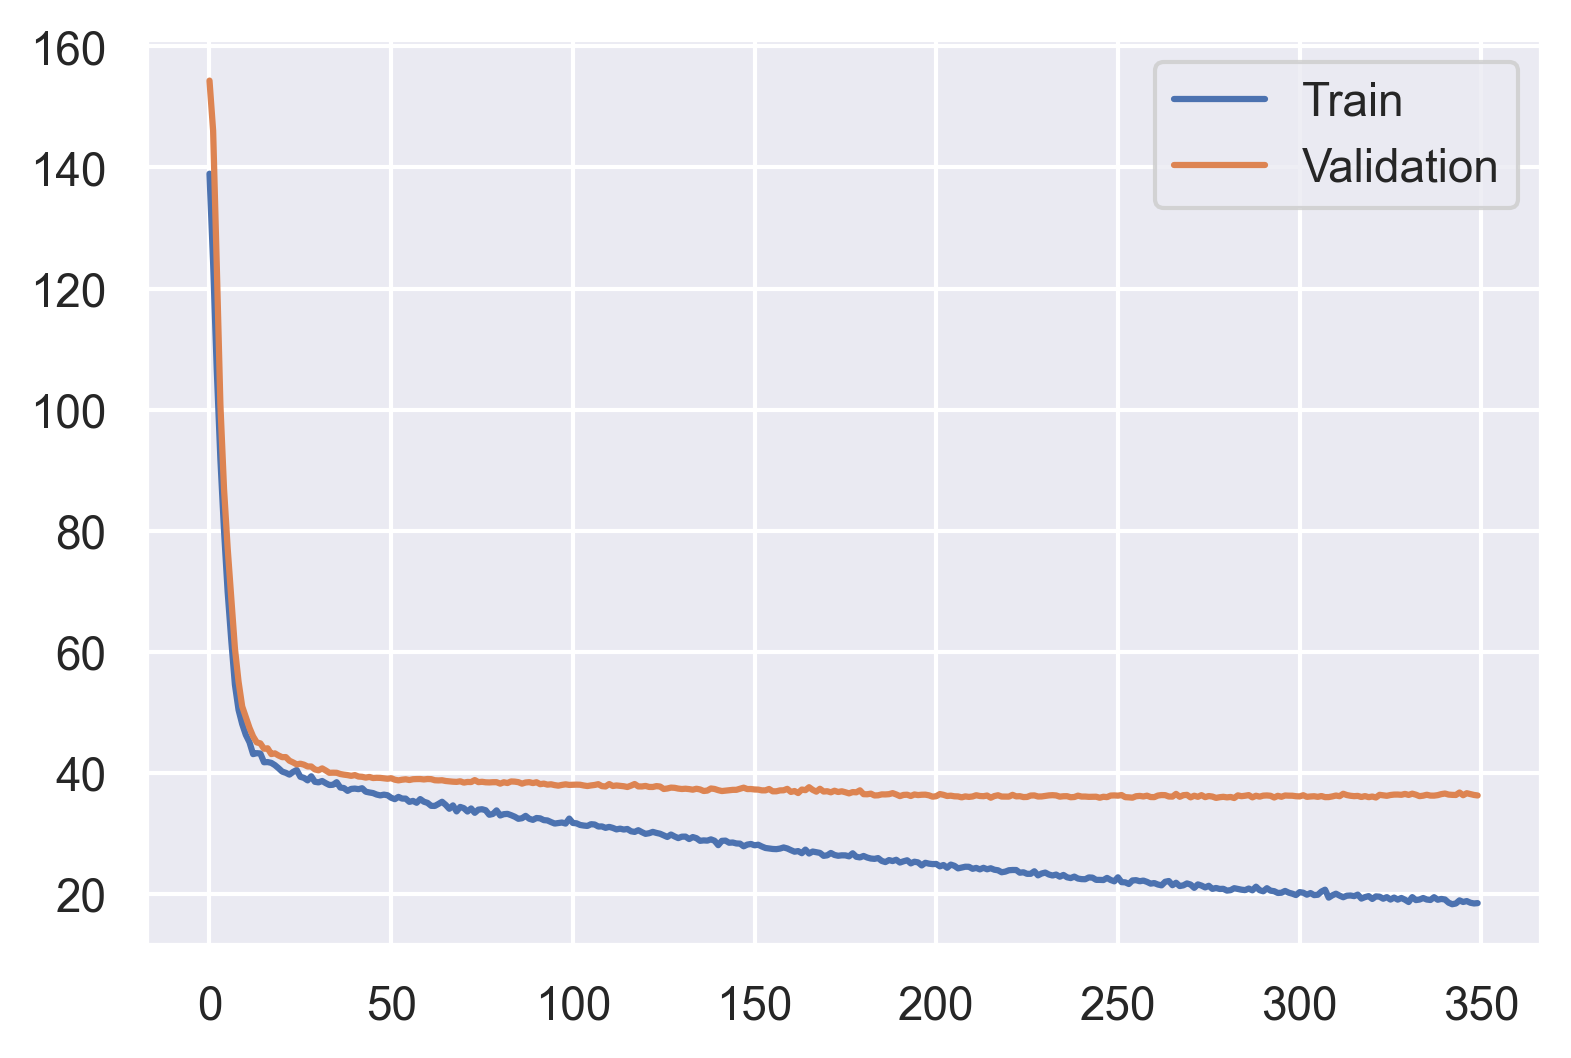

<Figure size 432x288 with 0 Axes>

In [37]:
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


### RMSE Train vs Validation Curve

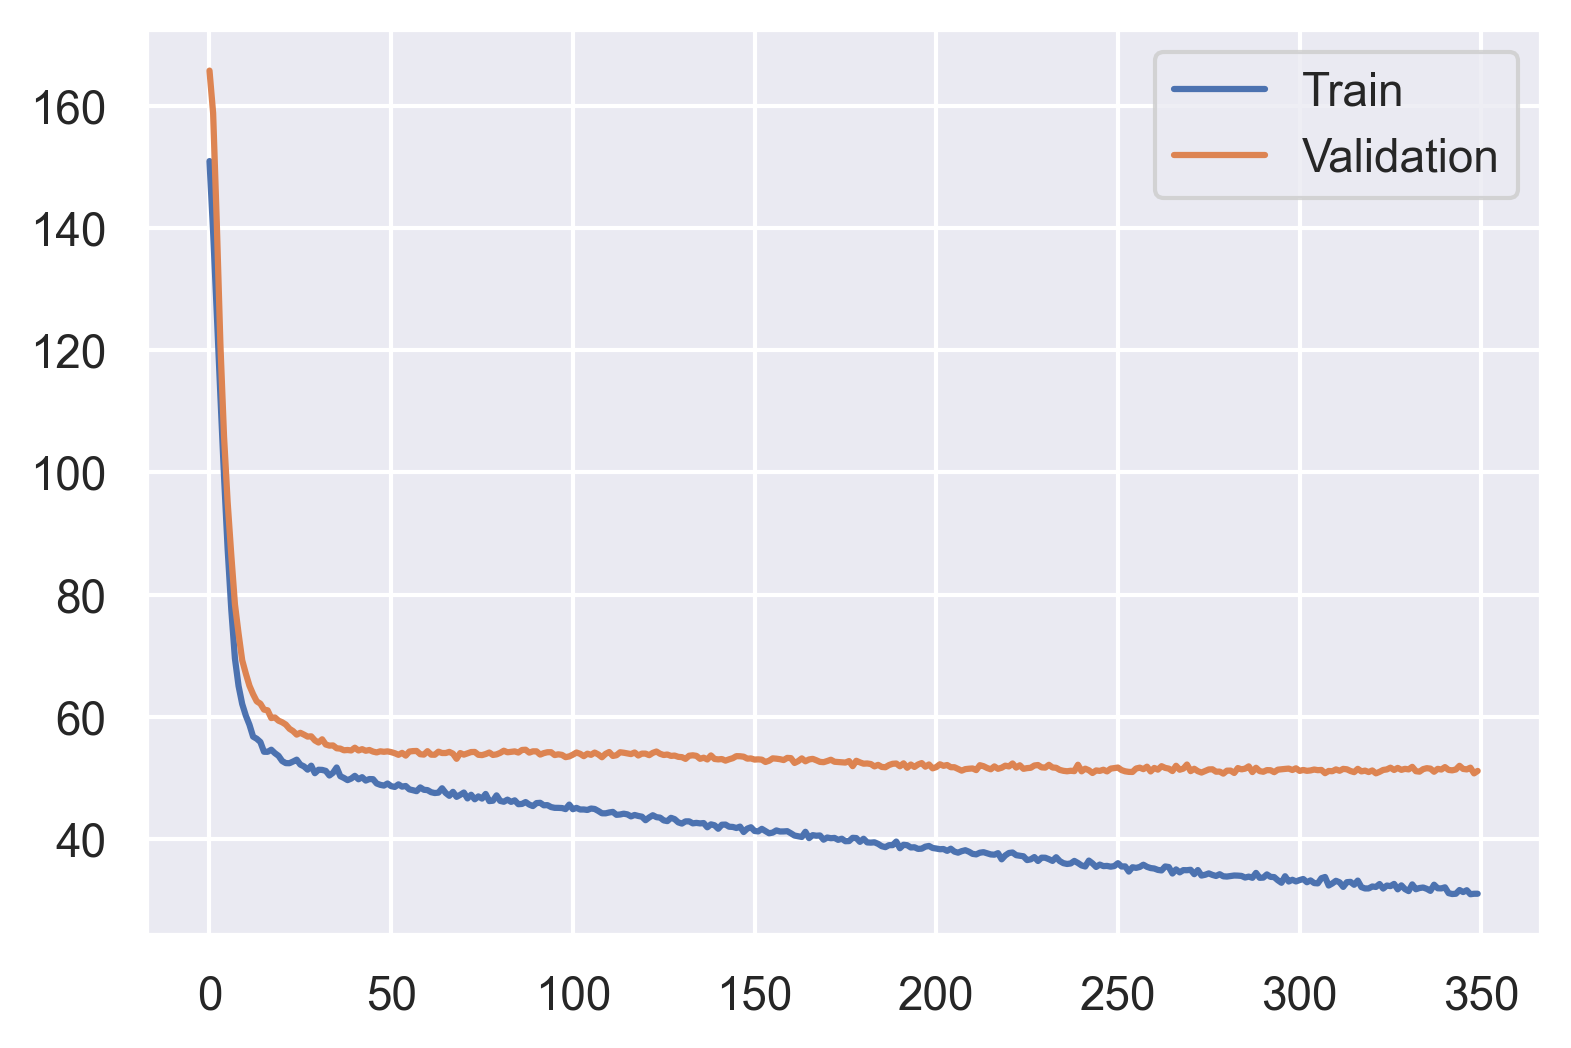

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(hist.history['root_mean_squared_error'], label='Train')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()
plt.savefig('LossVal_loss_nonaugmented')


In [39]:
print(len(x_test)) # Test data size

182


### Near Values

In [ ]:
check_20 = 0 #check how many differences are less or equal 20
check_30 = 0 #check how many differences are less or equal 30
check_40 = 0 #check how many differences are less or equal 40
check_50 = 0 #check how many differences are less or equal 60
check_10 = 0 #check how many differences are less 10
check_50_more = 0 #check how many differences are more than 50
check_0 = 0
check_below_50 = 0
total=0
# for i in diff:
#     if i == 0:
#         check_0 = check_0 + 1
#         total+=1
#     elif i <= 10:
#         check_10 = check_10 + 1
#         total+=1
#     elif i <= 20:
#         total+=1
#         check_20 = check_20 + 1
#     elif i <= 30:
#         total+=1
#         check_30 = check_30 + 1
#     elif i <= 40:
#         total+=1
#         check_40 = check_40 + 1
#     elif i <= 50:
#         total+=1
#         check_50 = check_50 + 1
#     elif i > 50:
#         check_50_more = check_50_more + 1
#         # print("Too far")
j = 0
for i in diff:
    j = j + 1
    if i < 50:
        total+=1
        check_below_50 = check_below_50 + 1
    elif i >= 50:
        # print(j-1)
        check_50_more = check_50_more + 1
        # print("Too far")


# print(check_0)
# print(check_10)
# print(check_20)
print("# of pictures of AQI Difference of less than 50: ", check_below_50)
print("# of pictures of AQI Difference of 50 or more: ", check_50_more)
# print('Near:',total)

3
11
14
15
16
18
19
27
30
44
47
59
60
68
74
78
85
94
95
105
109
113
121
126
130
131
142
151
153
158
164
168
170
175
# of pictures of AQI Difference of less than 50:  148
# of pictures of AQI Difference of 50 or more:  34


In [89]:
near_percentage = (total/len(x_test) )* 100 # This percent of images can be considered as truly close to actual value since 50 difference is.

In [90]:
print(near_percentage)

81.31868131868131


### Test Dataset Amount

In [43]:
len(x_test)

182

In [44]:
predic=[]
obser=[]
for i in range(len(pred)):
    predic.append(pred[i])
    obser.append(y_test[i])

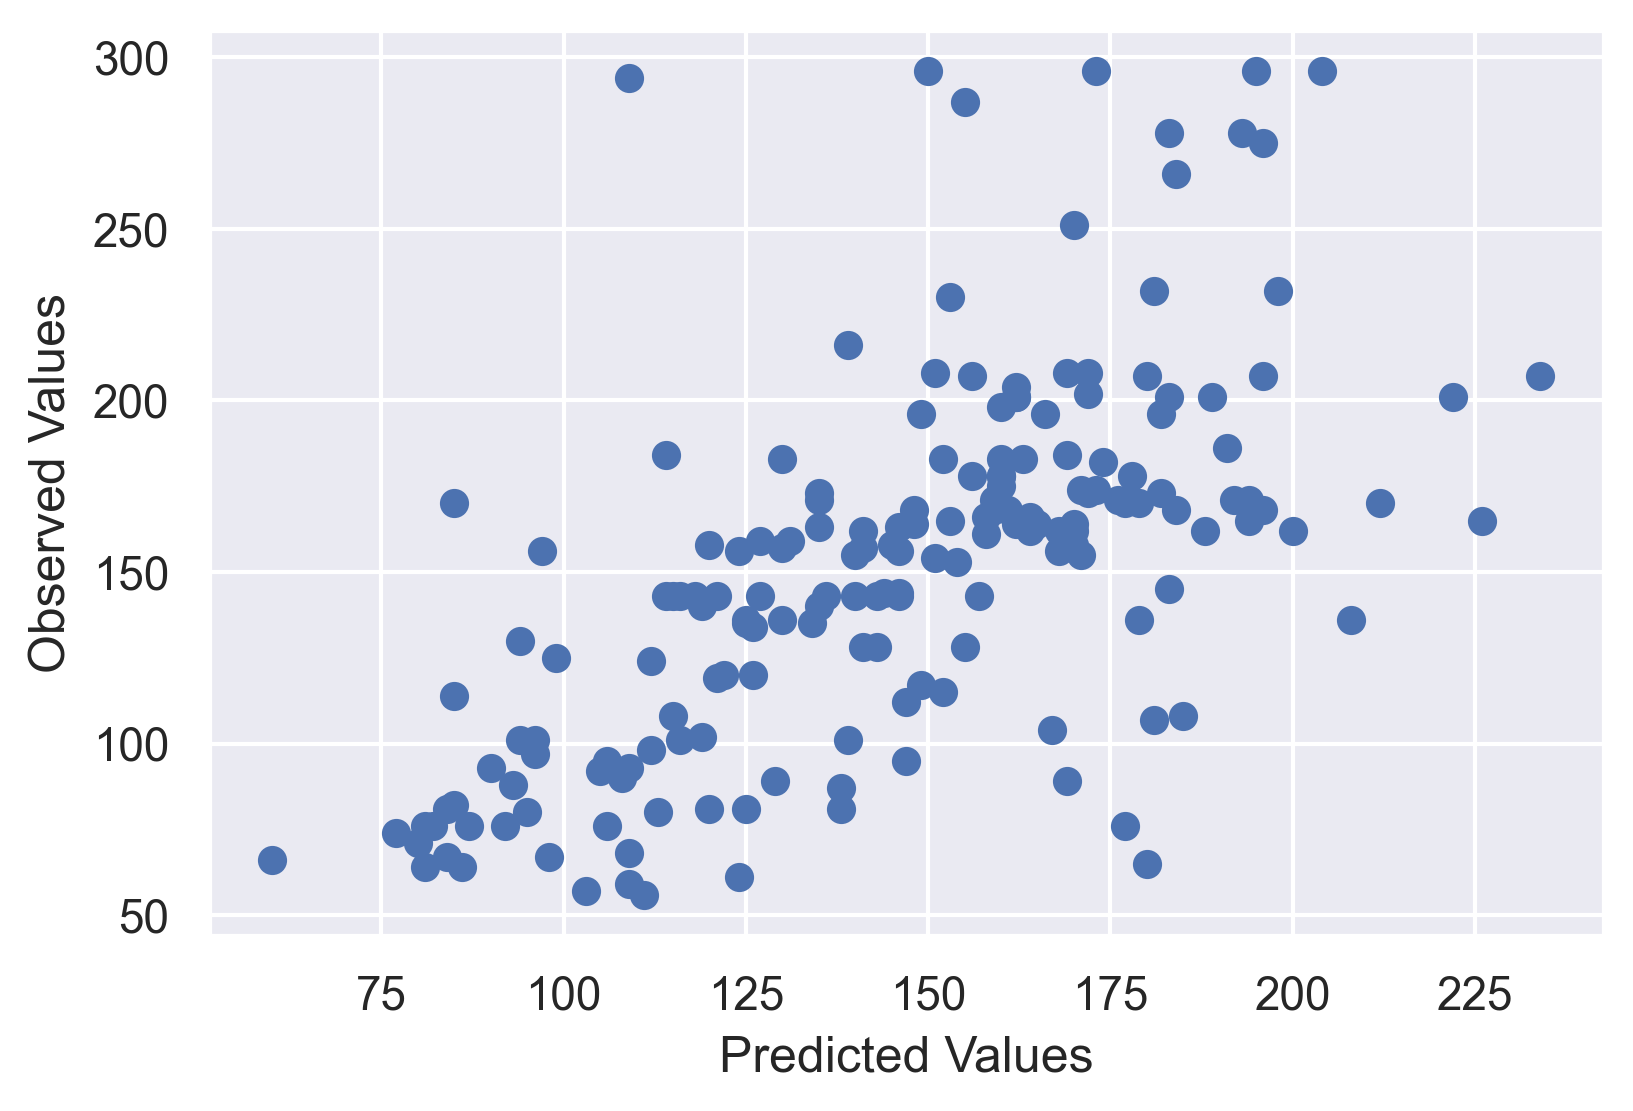

In [45]:
xpoints = np.array(predic)
ypoints = np.array(obser)

plt.scatter(xpoints, ypoints)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.gcf().set_dpi(300)
plt.show()


In [46]:
my_rho = np.corrcoef(predic, obser)

print(my_rho)

[[1.         0.63039796]
 [0.63039796 1.        ]]


In [47]:
losas= tf.keras.metrics.mean_absolute_error(obser, predic)

In [48]:
losas

<tf.Tensor: shape=(), dtype=int32, numpy=29>

## $R^2$ Score

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(obser, predic)

In [50]:
print(r2)

0.3869321241555579


In [51]:
print(x_test)

[[[[0.7529412  0.7647059  0.7882353 ]
   [0.74509805 0.75686276 0.78431374]
   [0.7529412  0.77254903 0.79607844]
   ...
   [0.6862745  0.7137255  0.7372549 ]
   [0.6901961  0.7294118  0.73333335]
   [0.6666667  0.7058824  0.70980394]]

  [[0.7607843  0.77254903 0.8       ]
   [0.75686276 0.76862746 0.7882353 ]
   [0.7529412  0.77254903 0.79607844]
   ...
   [0.7019608  0.7294118  0.7529412 ]
   [0.6901961  0.7176471  0.7372549 ]
   [0.6745098  0.7058824  0.7176471 ]]

  [[0.75686276 0.76862746 0.79607844]
   [0.75686276 0.76862746 0.7882353 ]
   [0.76862746 0.7882353  0.80784315]
   ...
   [0.69803923 0.7254902  0.7490196 ]
   [0.6784314  0.7137255  0.73333335]
   [0.6745098  0.7137255  0.72156864]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.5019608  0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

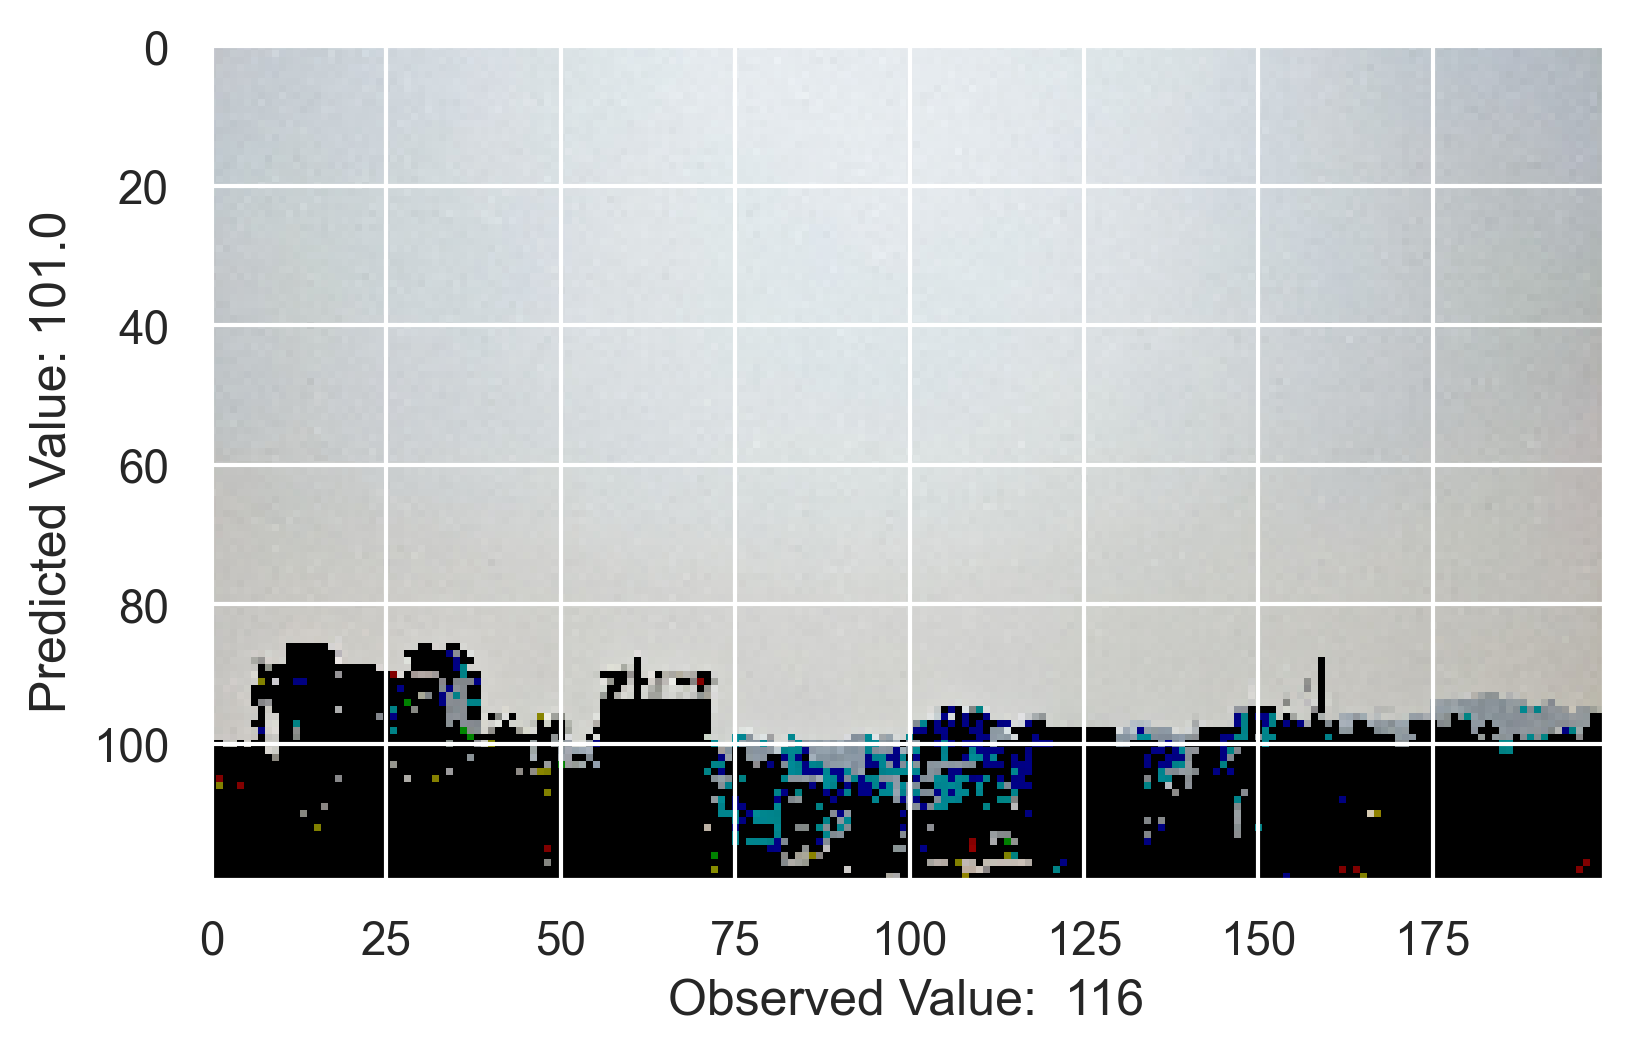

In [ ]:
from PIL import Image as im

val = 0

data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

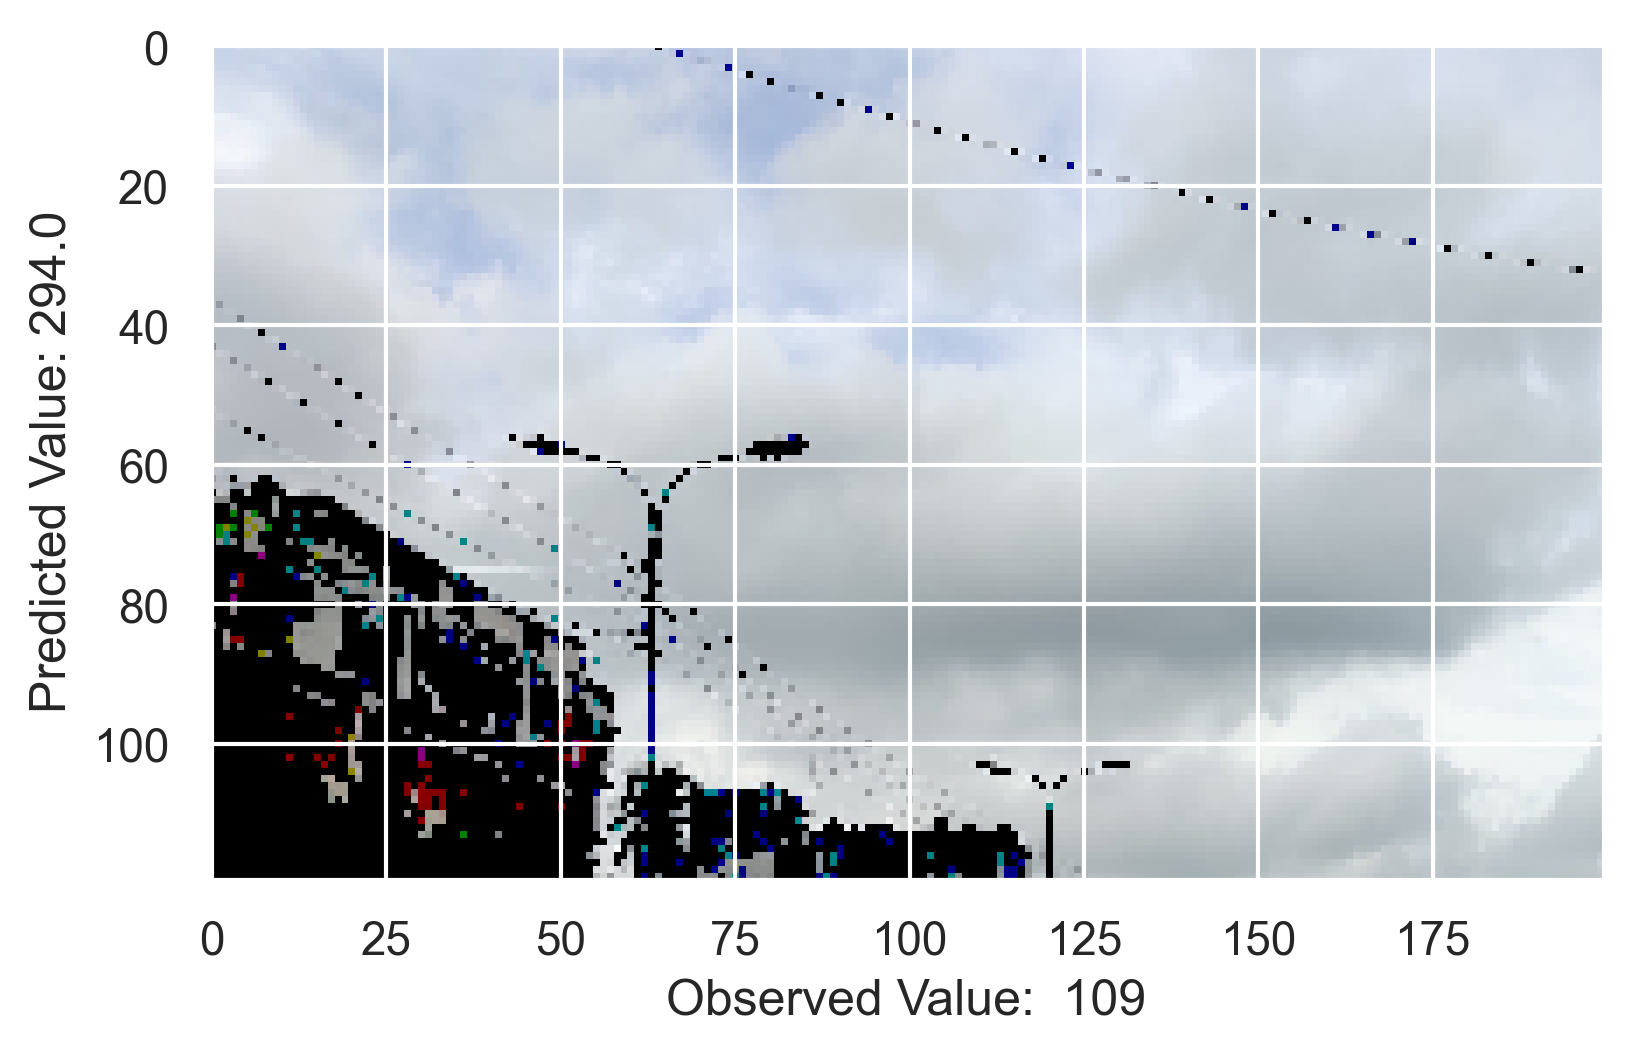

In [72]:
from PIL import Image as im

val = 3
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

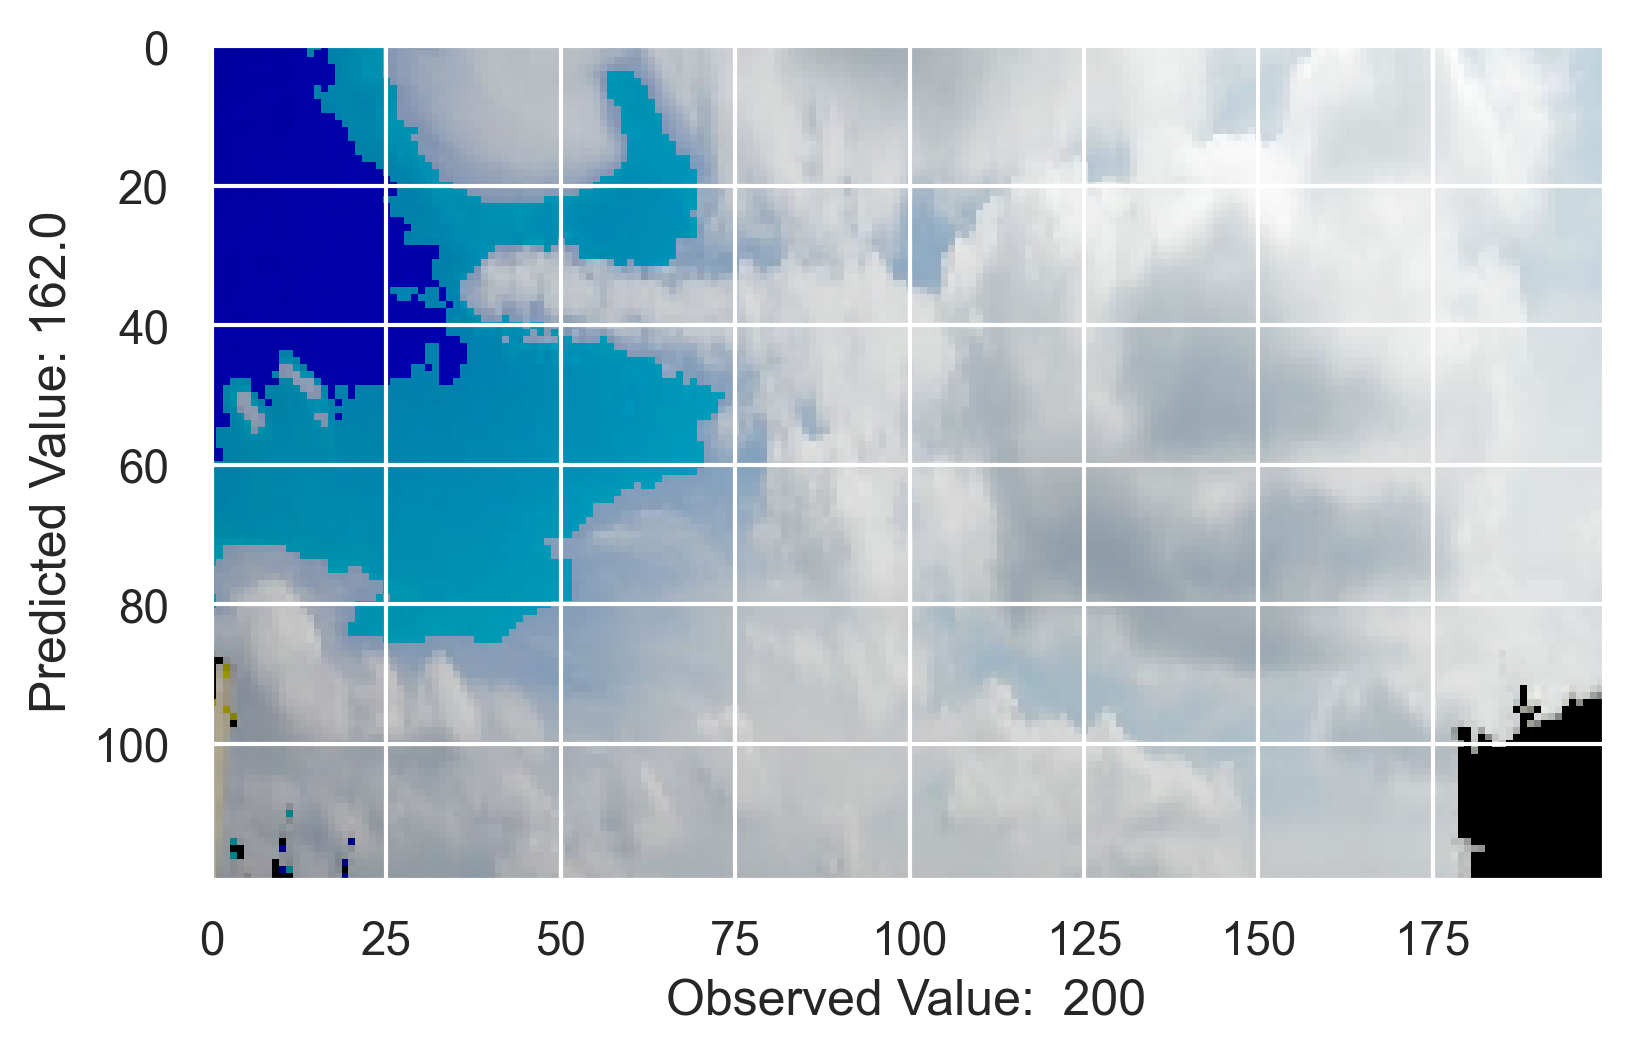

In [73]:
from PIL import Image as im

val = 4
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

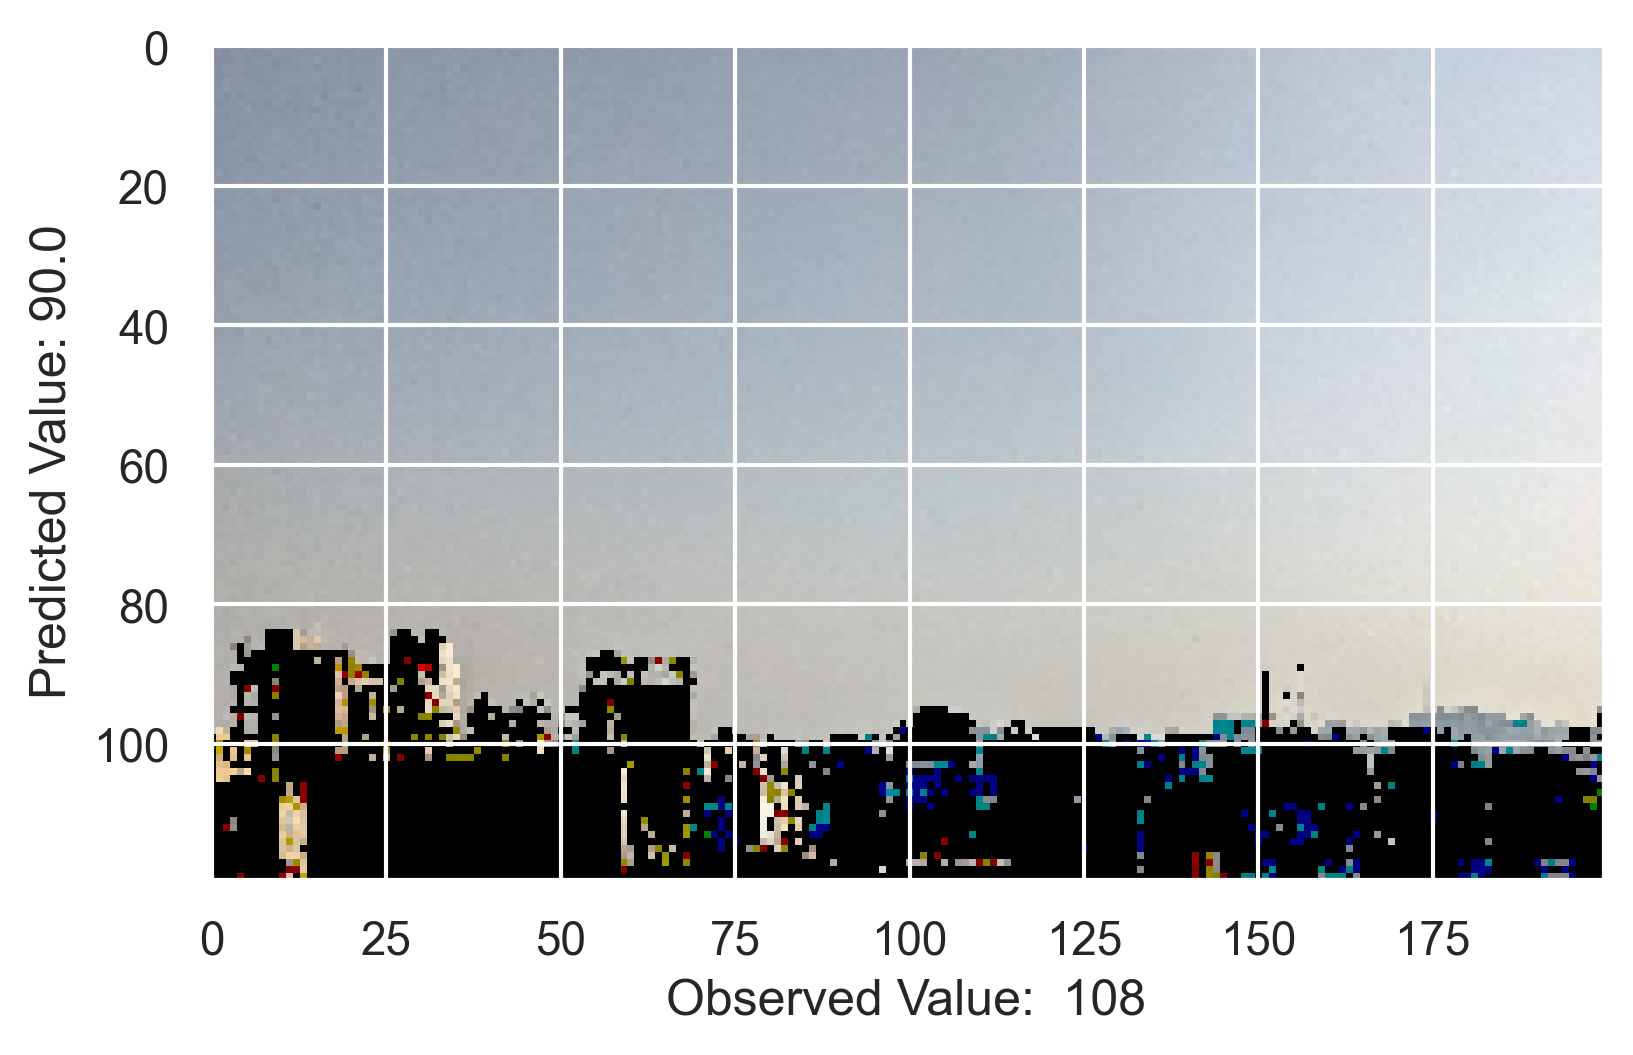

In [74]:
from PIL import Image as im

val = 5
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

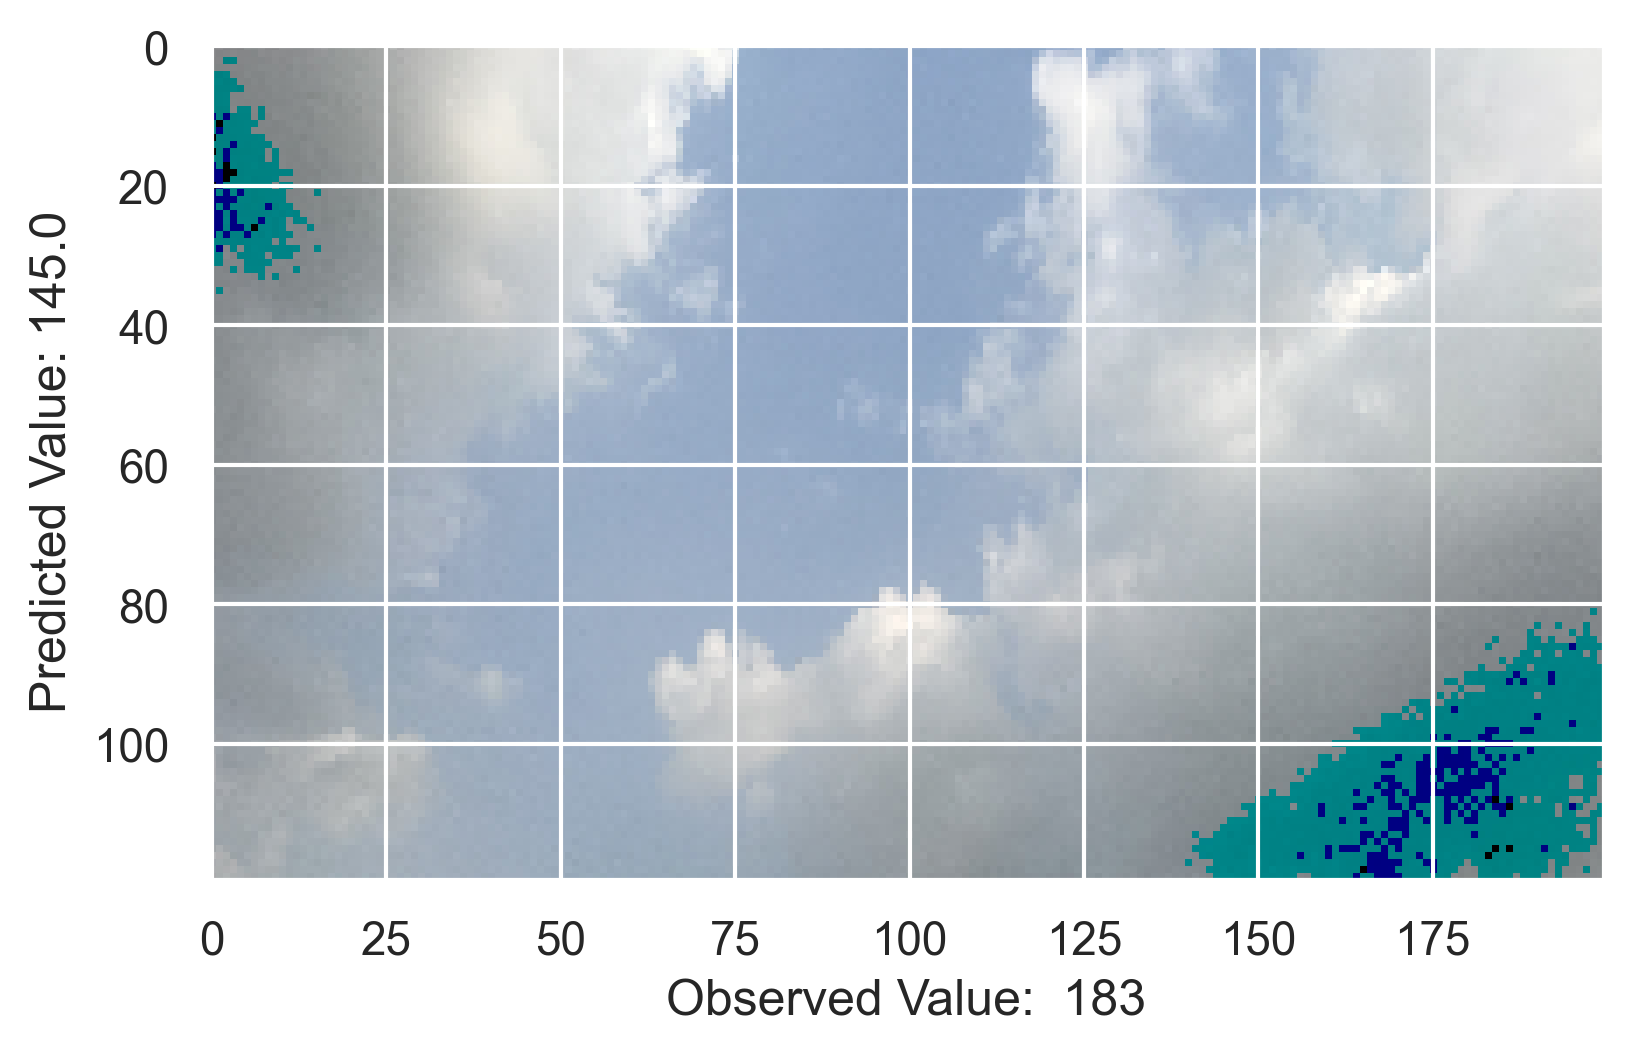

In [75]:
from PIL import Image as im

val = 6
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

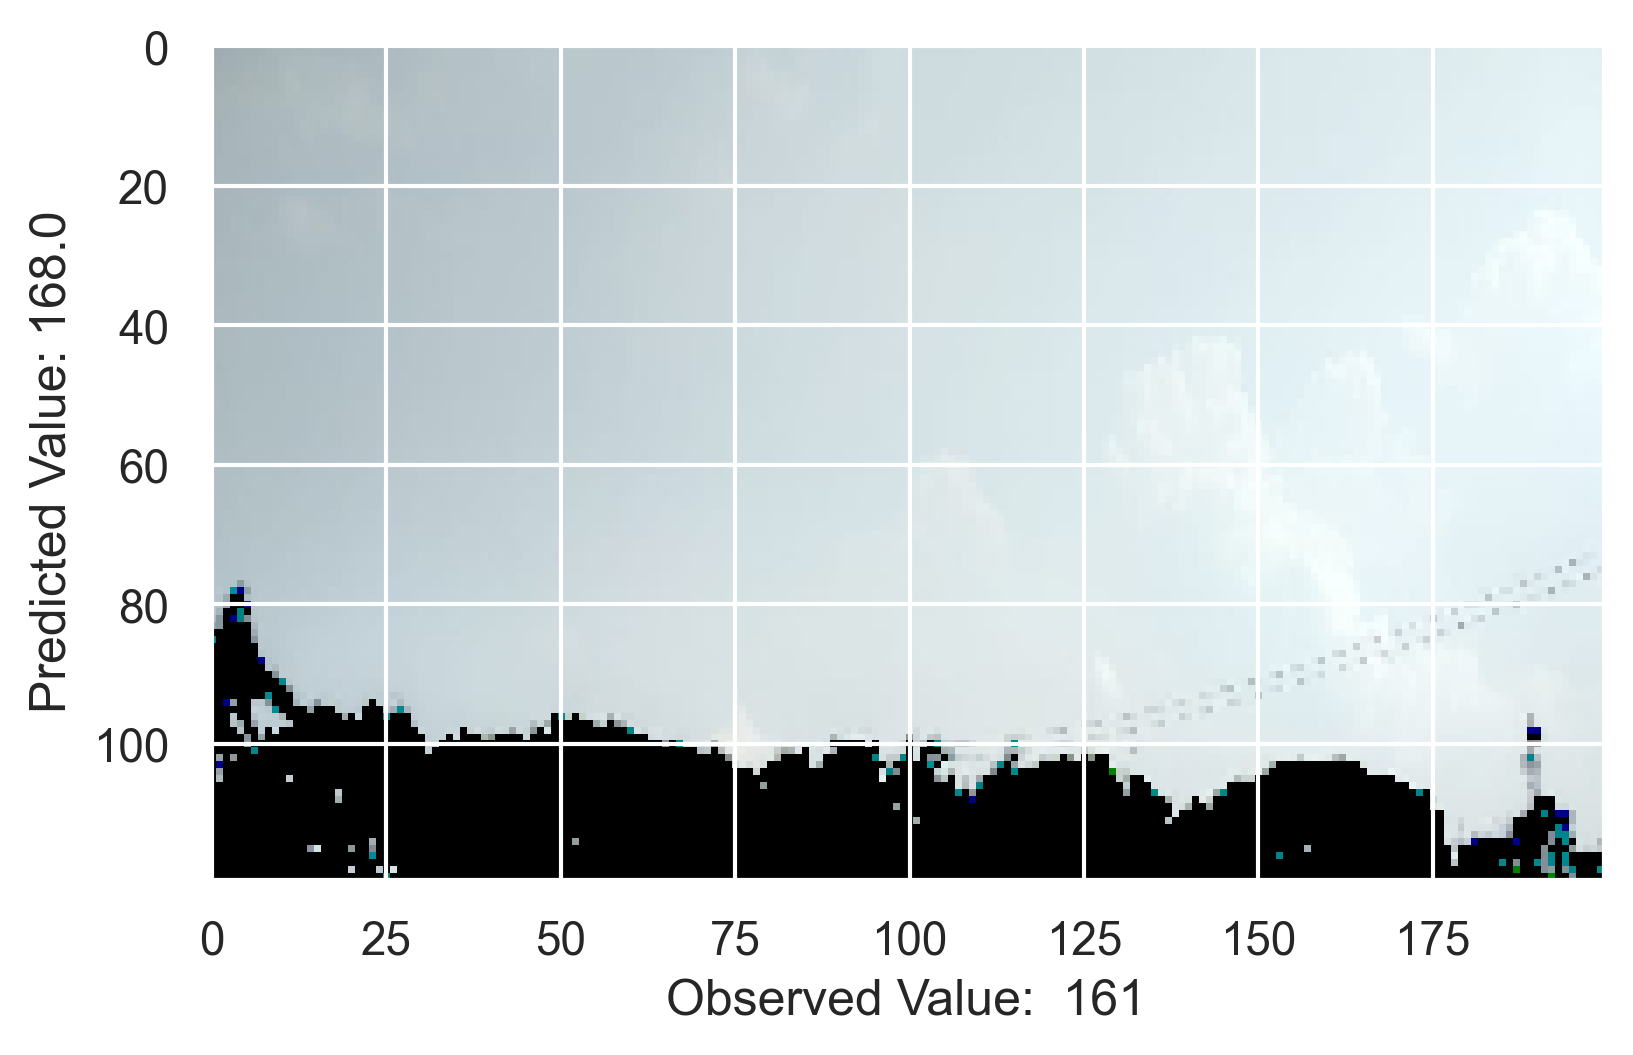

In [76]:
from PIL import Image as im

val = 7
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

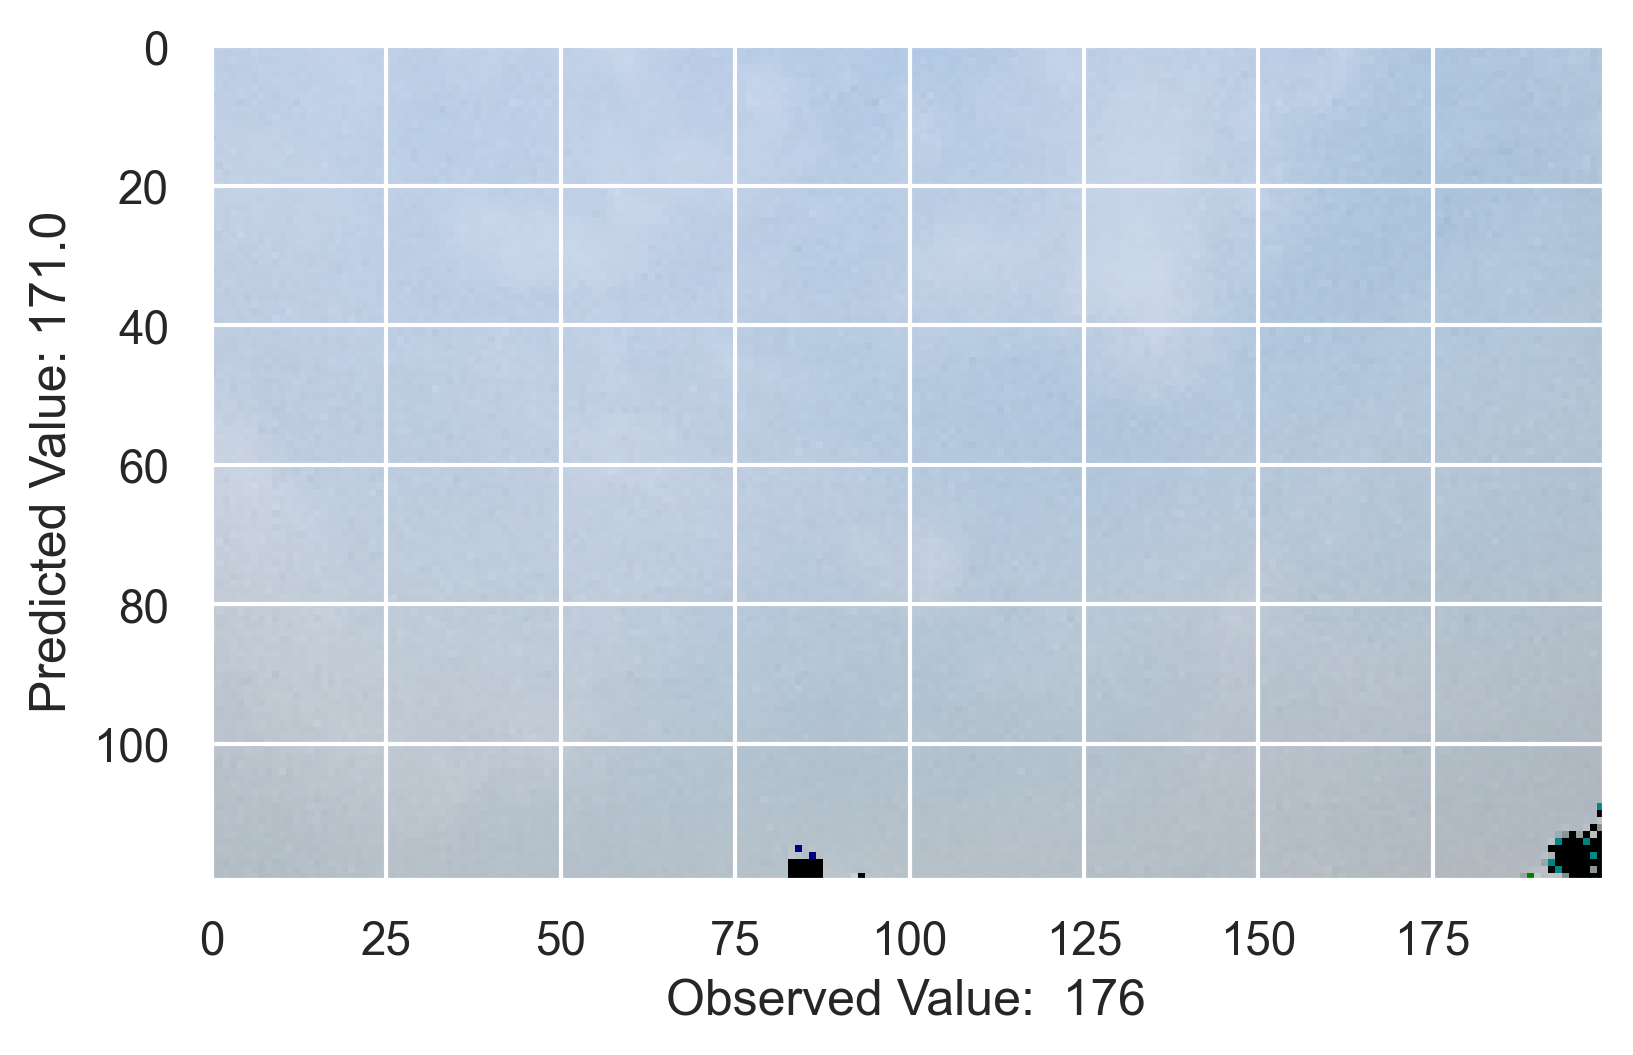

In [78]:
from PIL import Image as im

val = 10
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

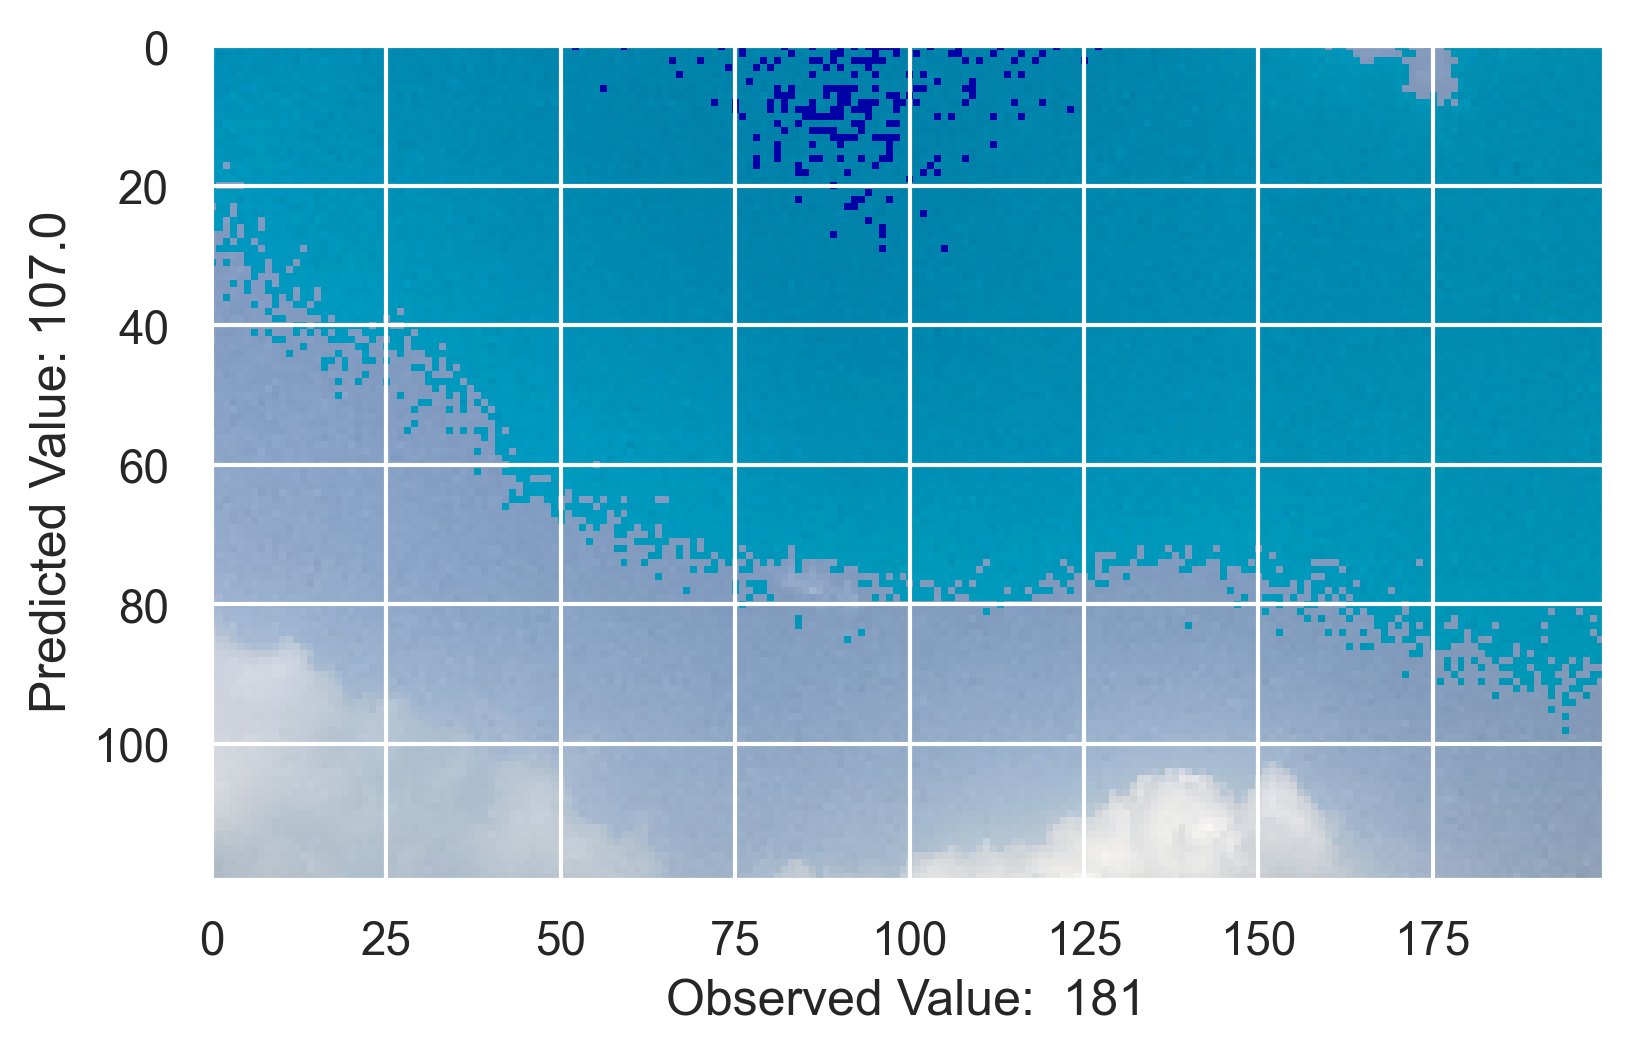

In [80]:
from PIL import Image as im

val = 11
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

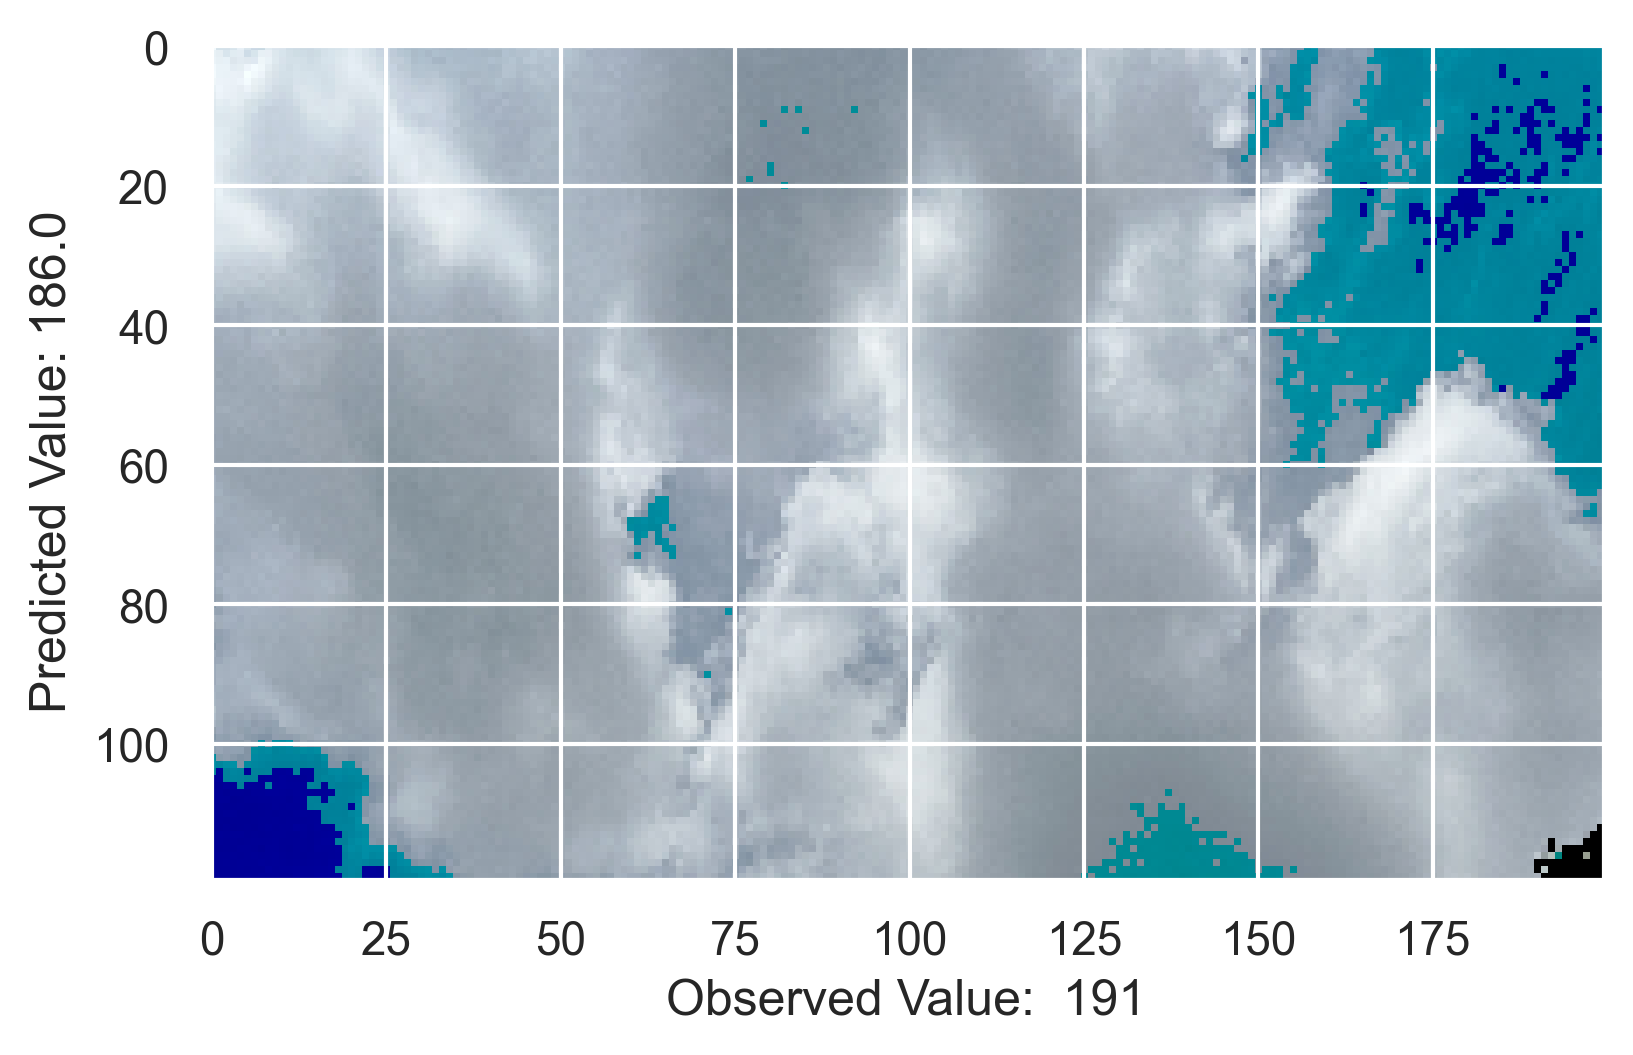

In [81]:
from PIL import Image as im

val = 12
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

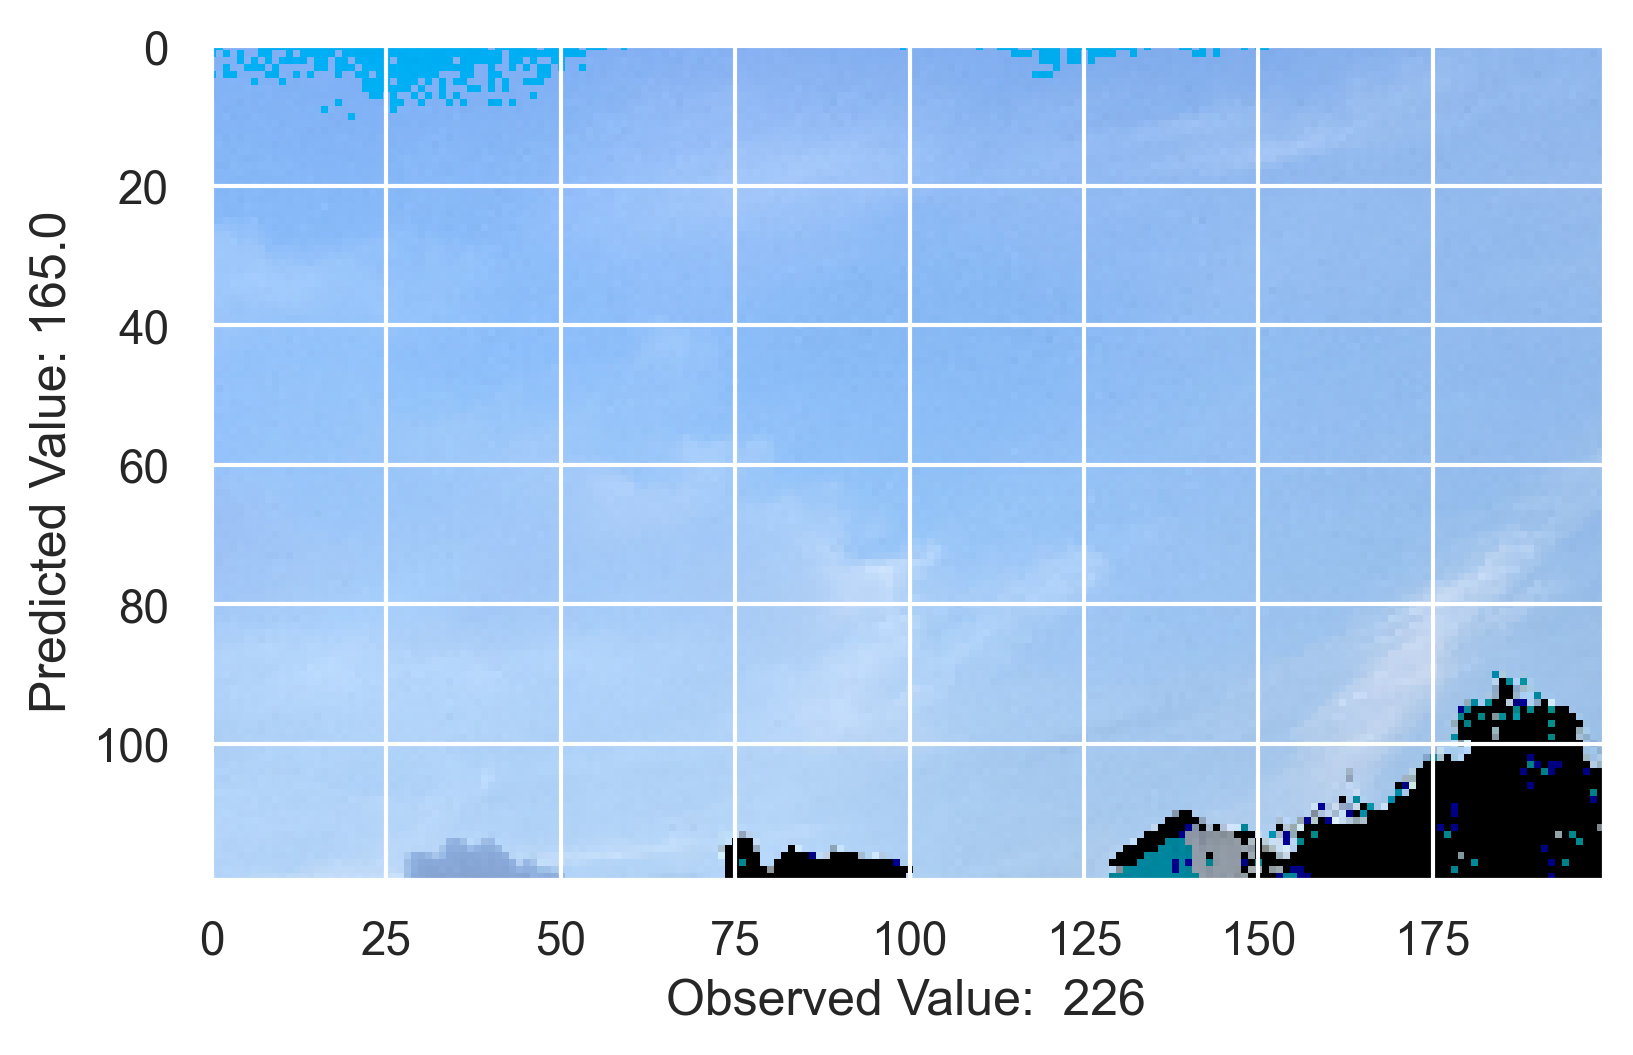

In [84]:
from PIL import Image as im

val = 14
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

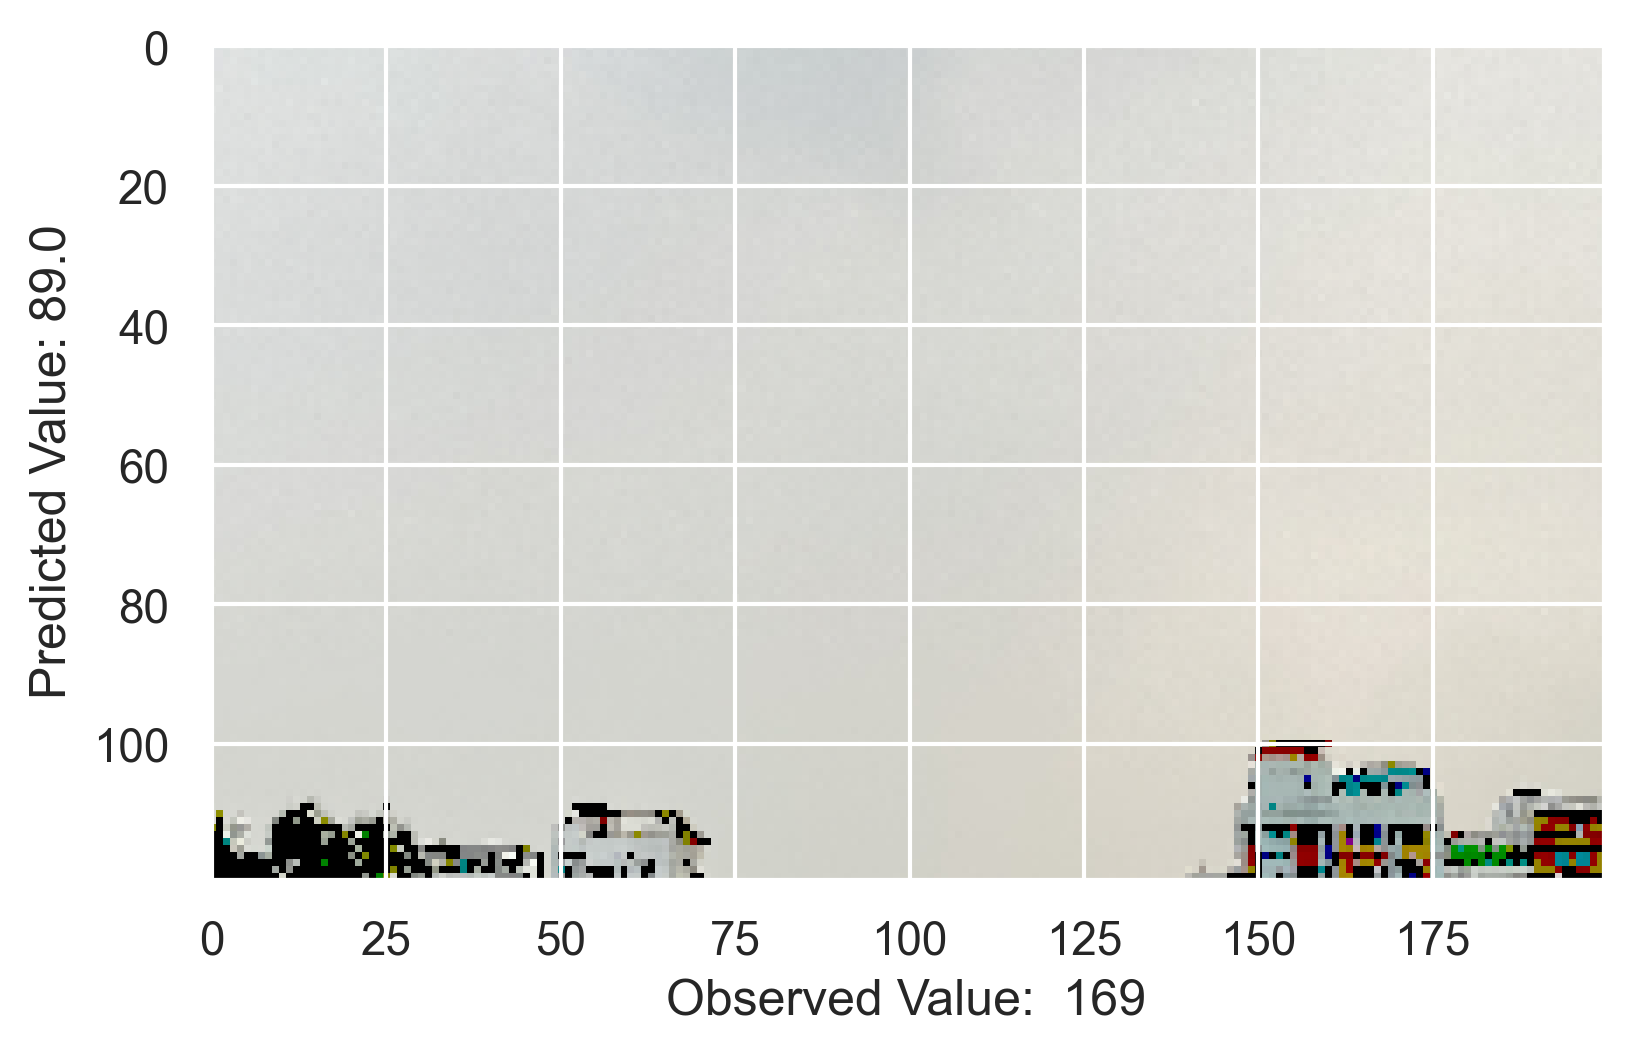

In [85]:
from PIL import Image as im

val = 15
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

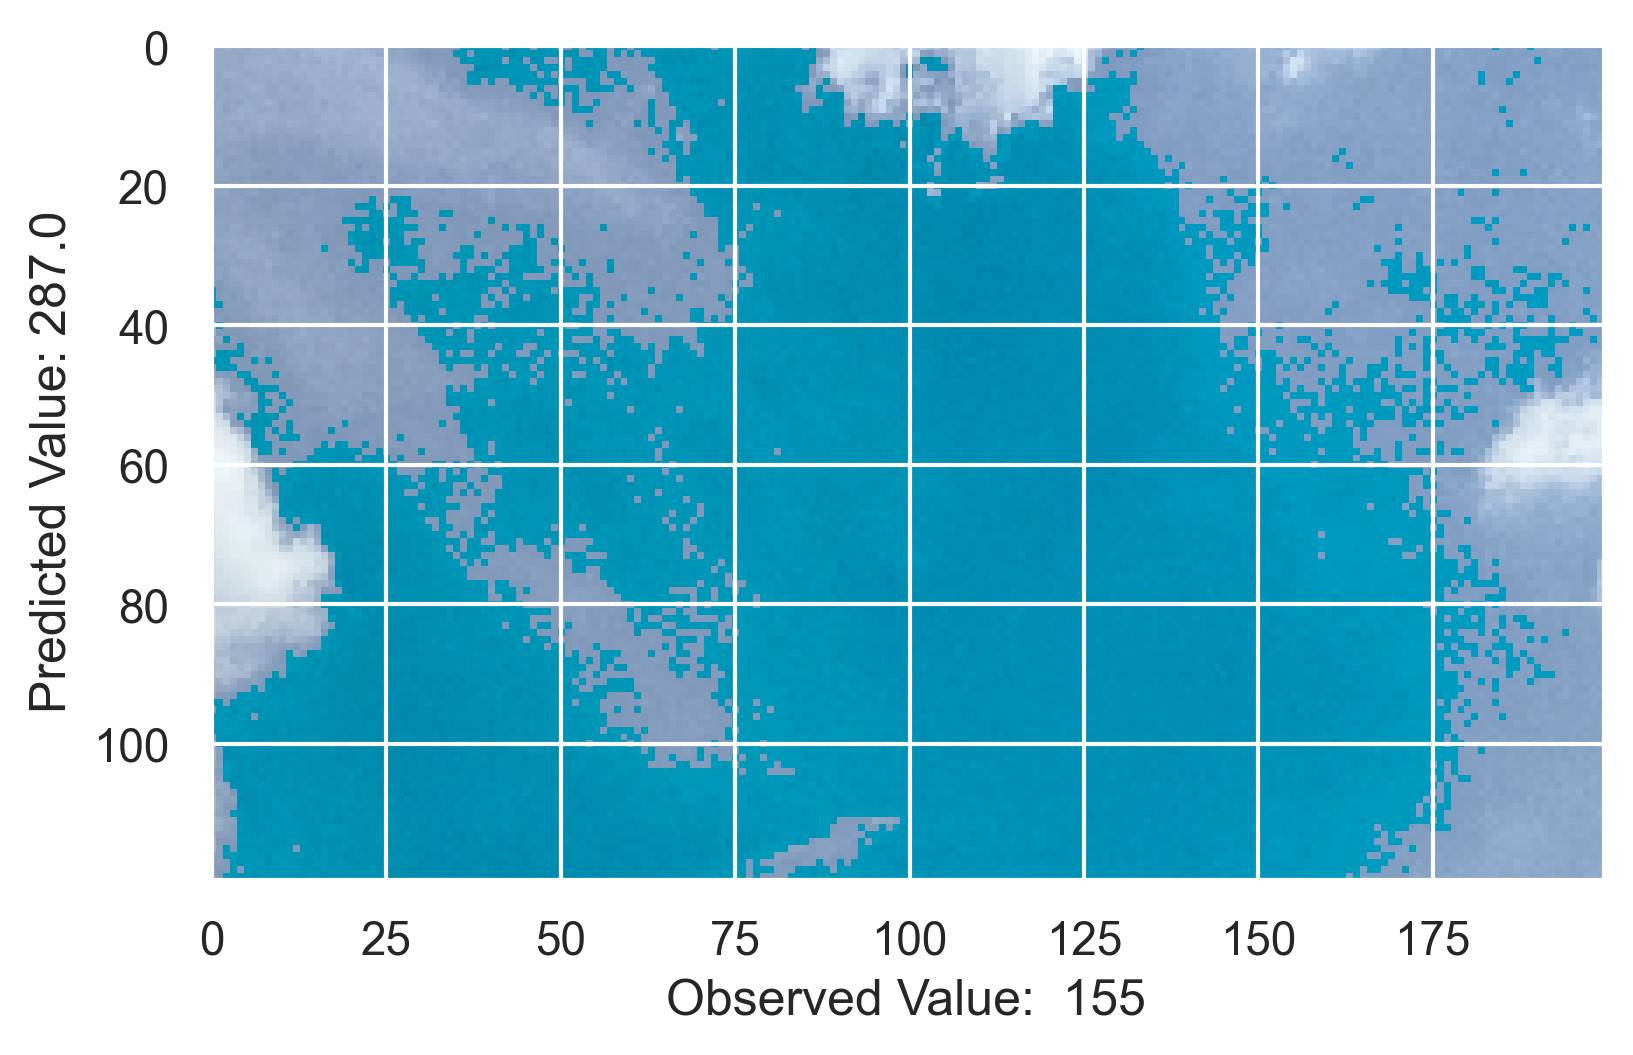

In [91]:
from PIL import Image as im

val = 16
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

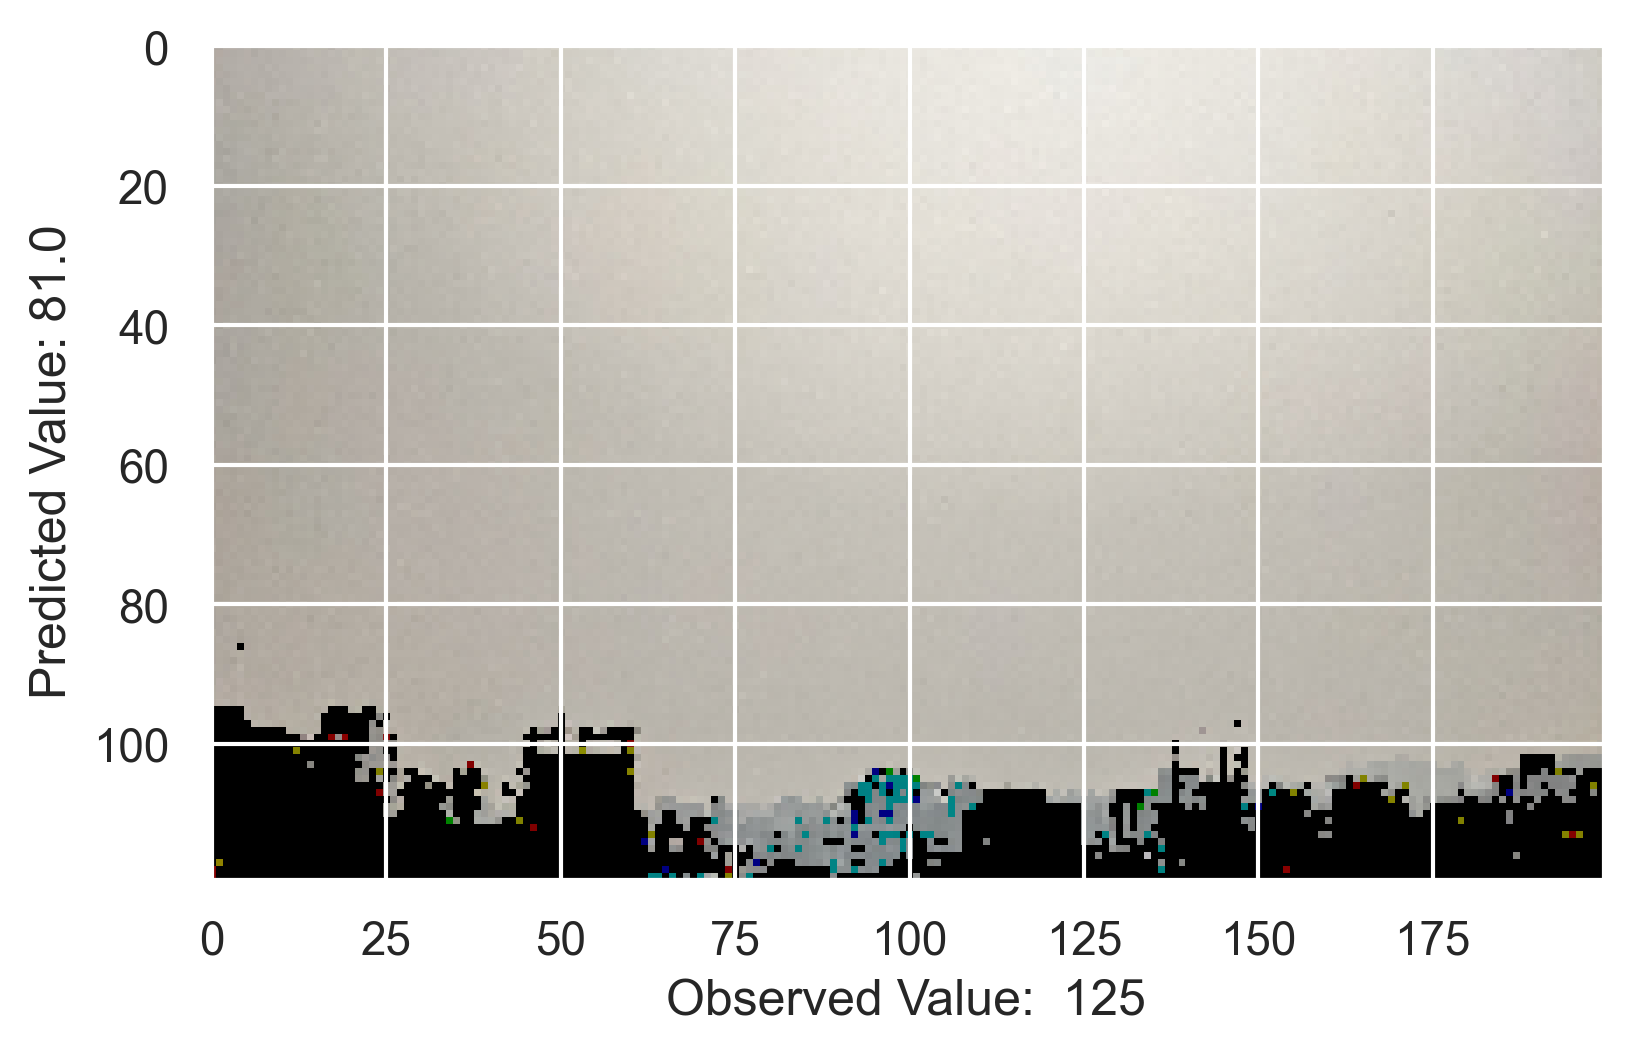

In [92]:
from PIL import Image as im

val = 17
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

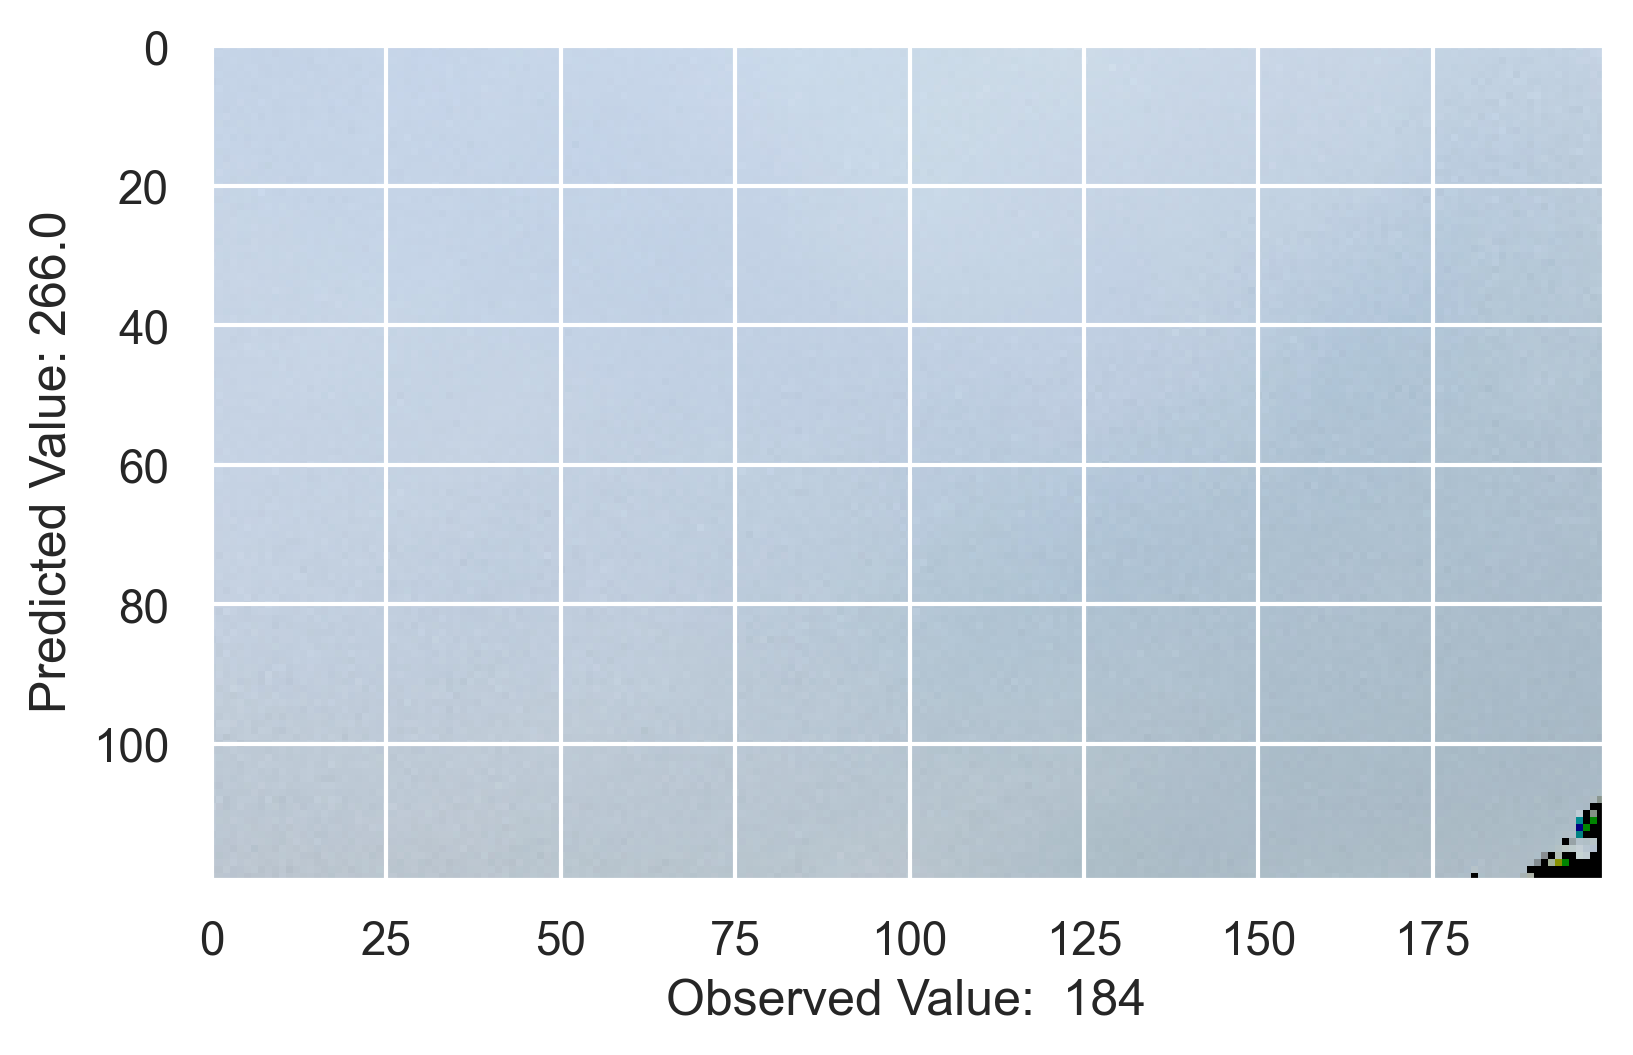

In [93]:
from PIL import Image as im

val = 18
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

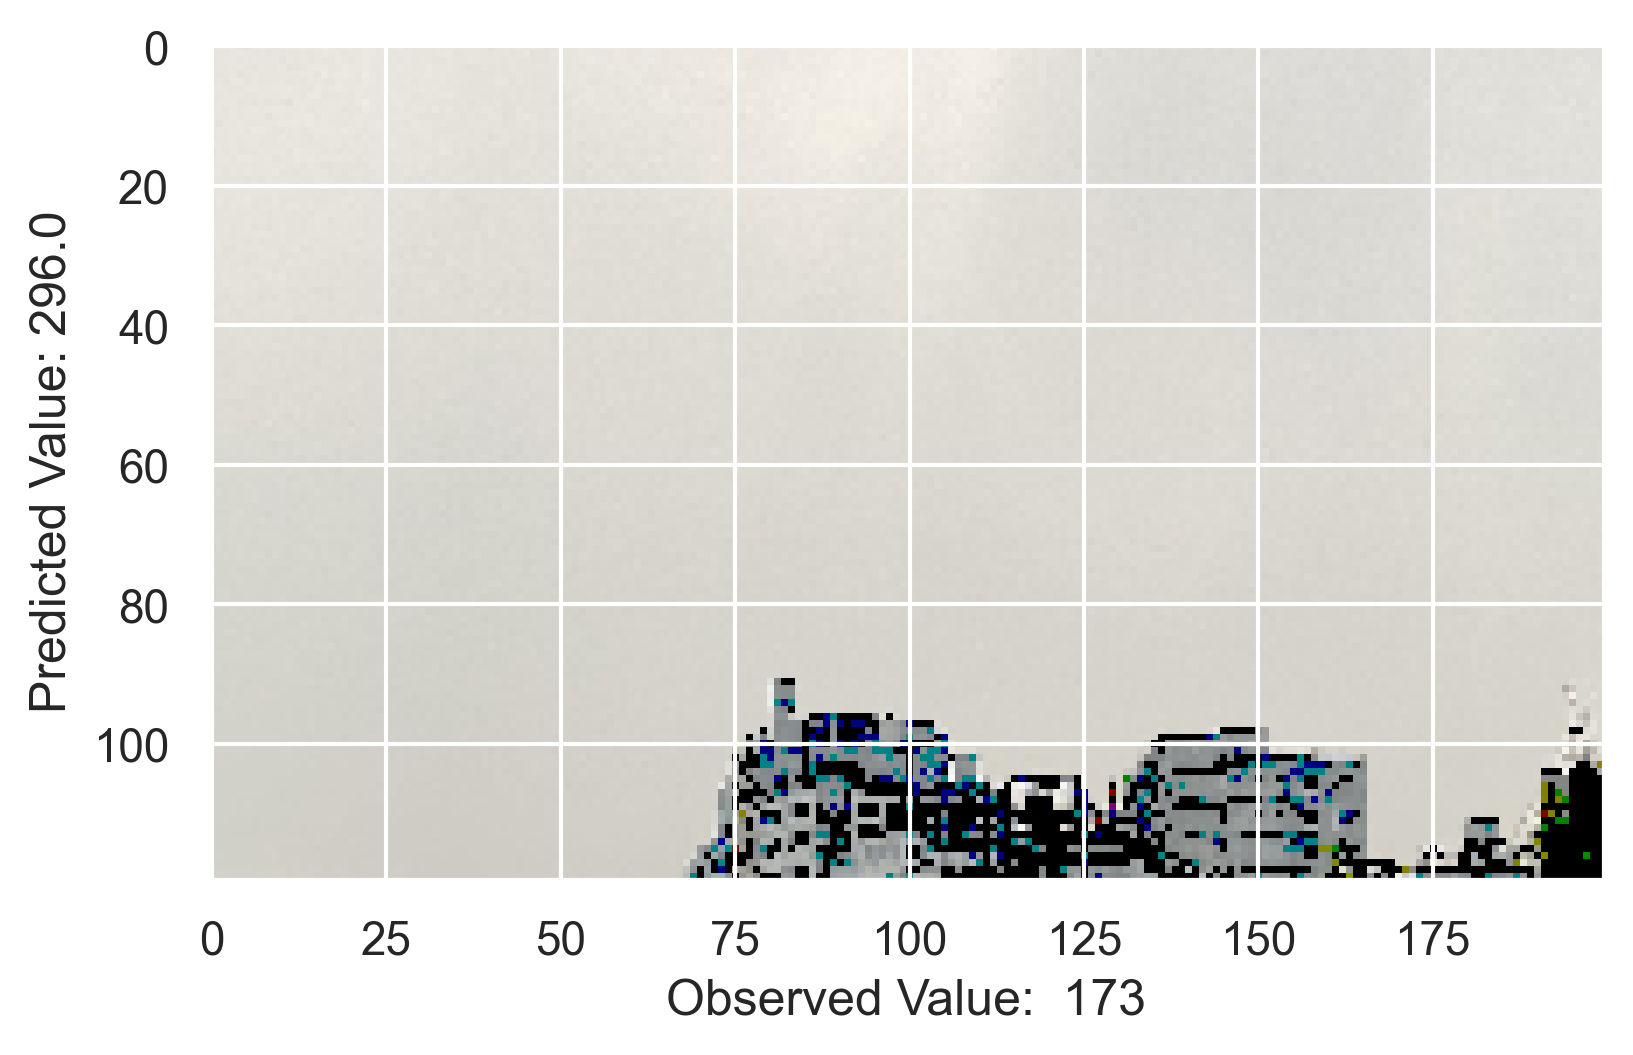

In [94]:
from PIL import Image as im

val = 19
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

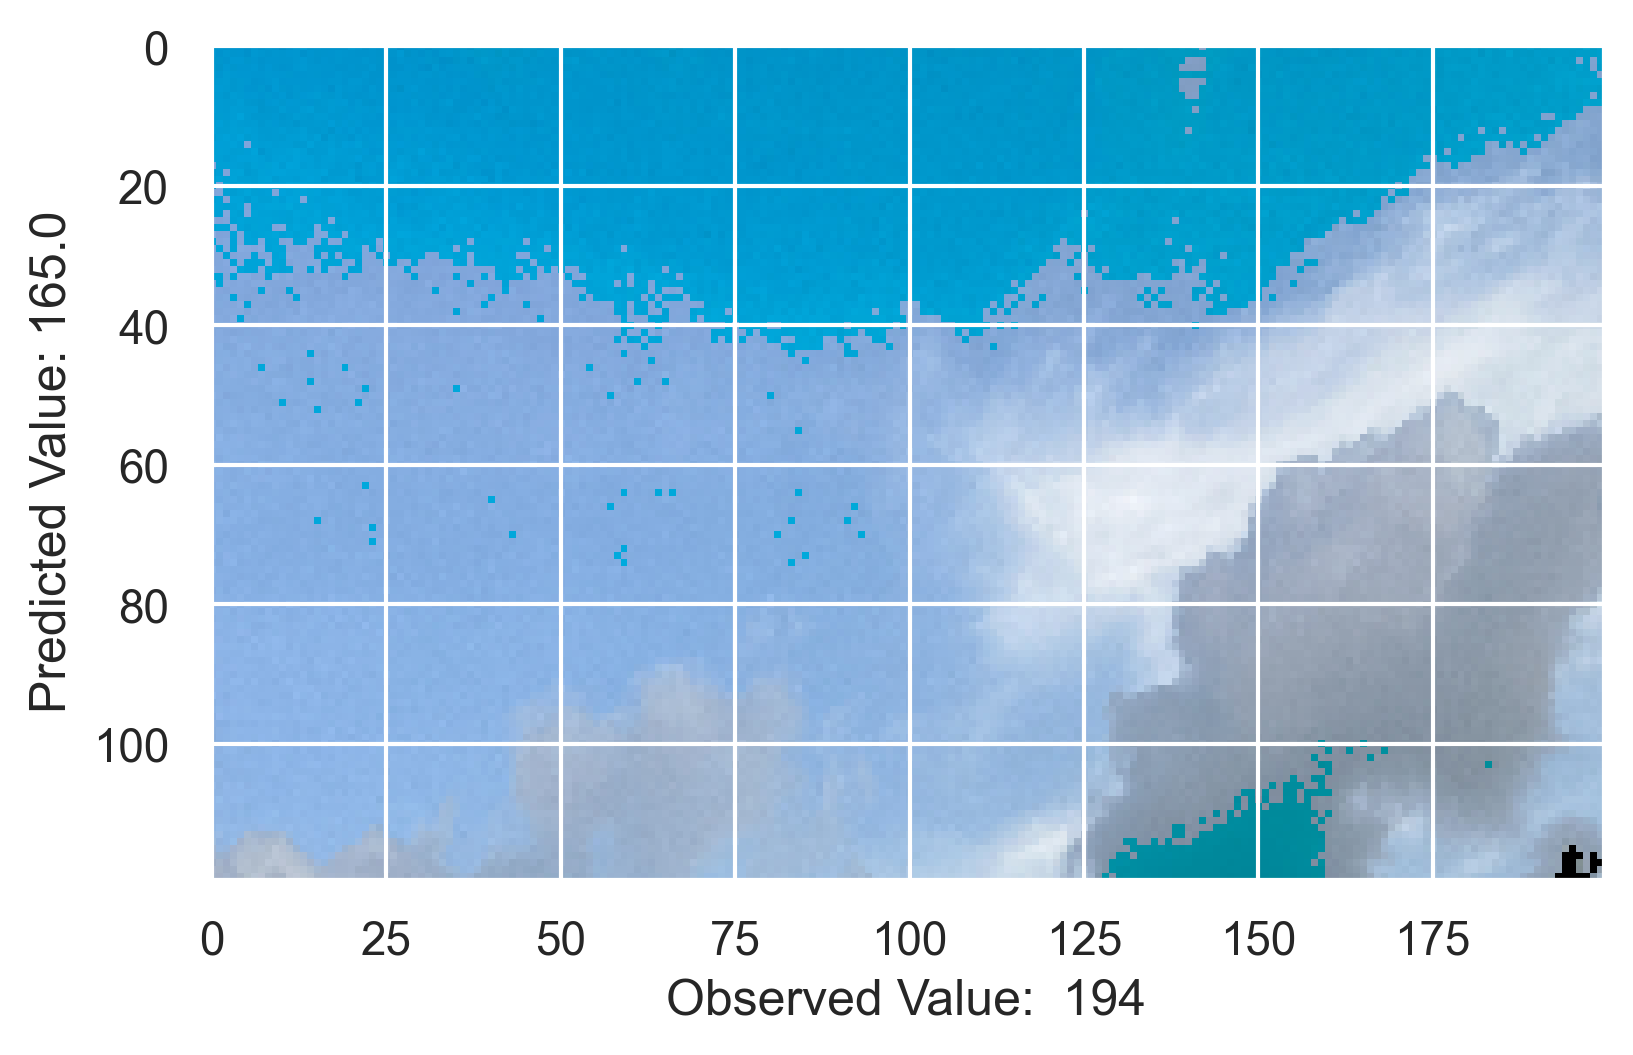

In [95]:
from PIL import Image as im

val = 20
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

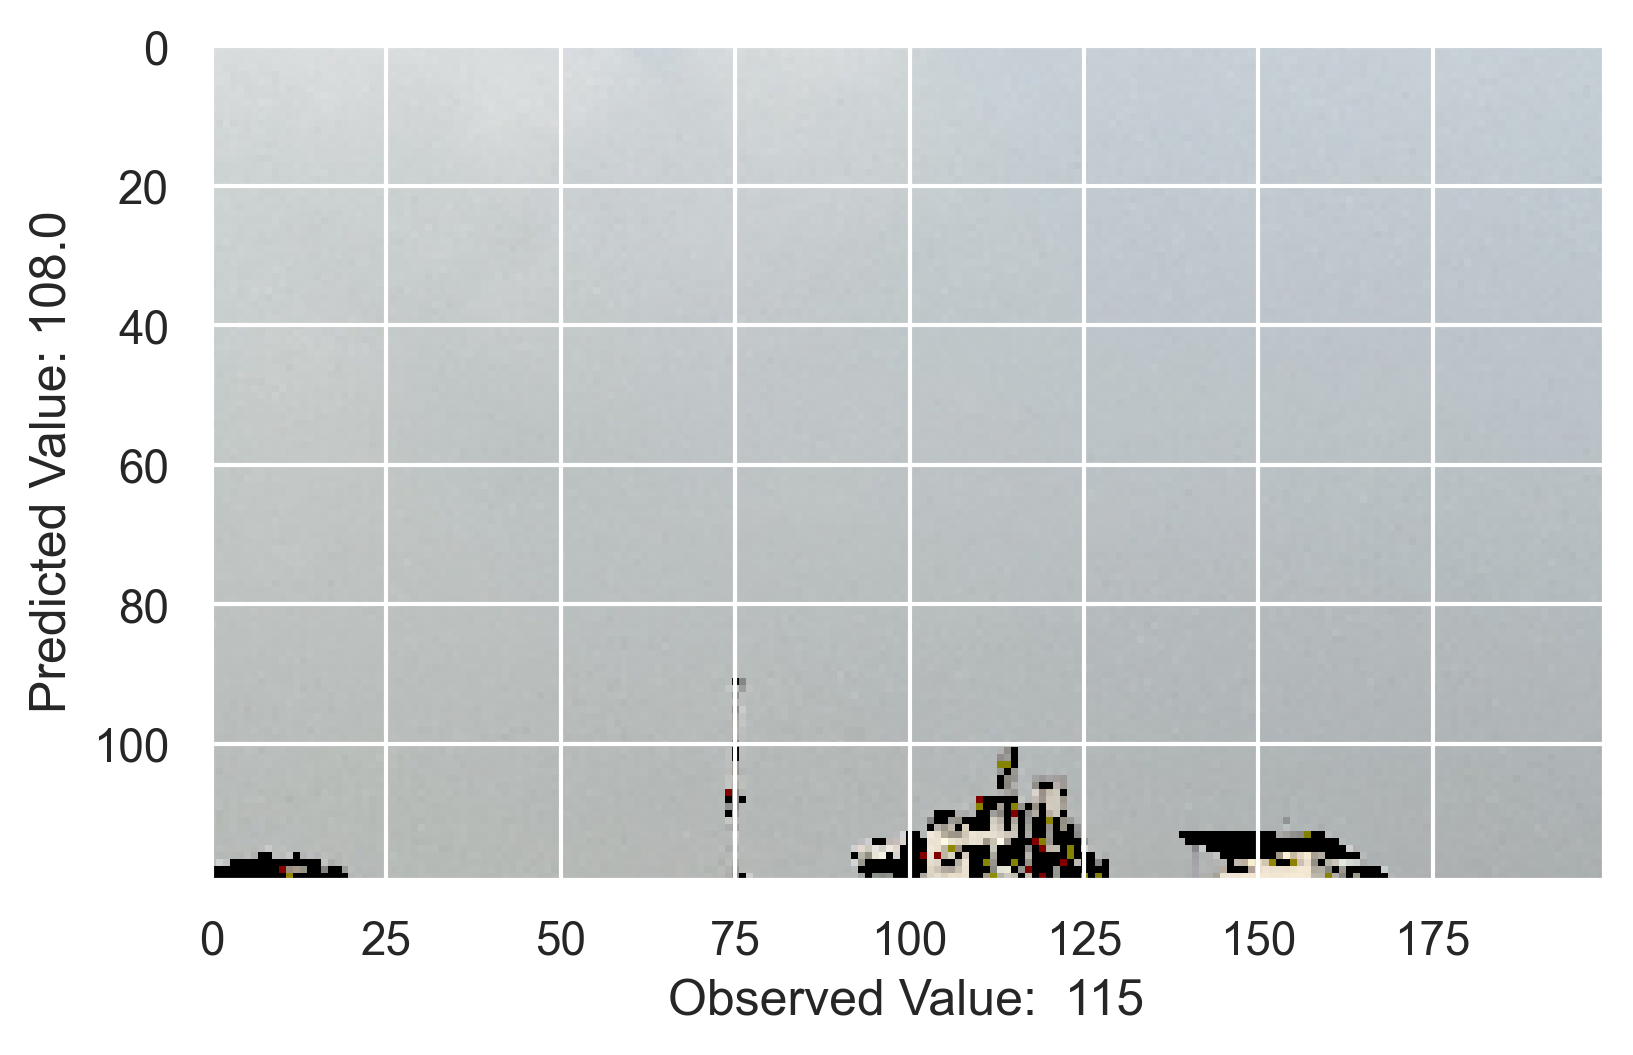

In [96]:
from PIL import Image as im

val = 21
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

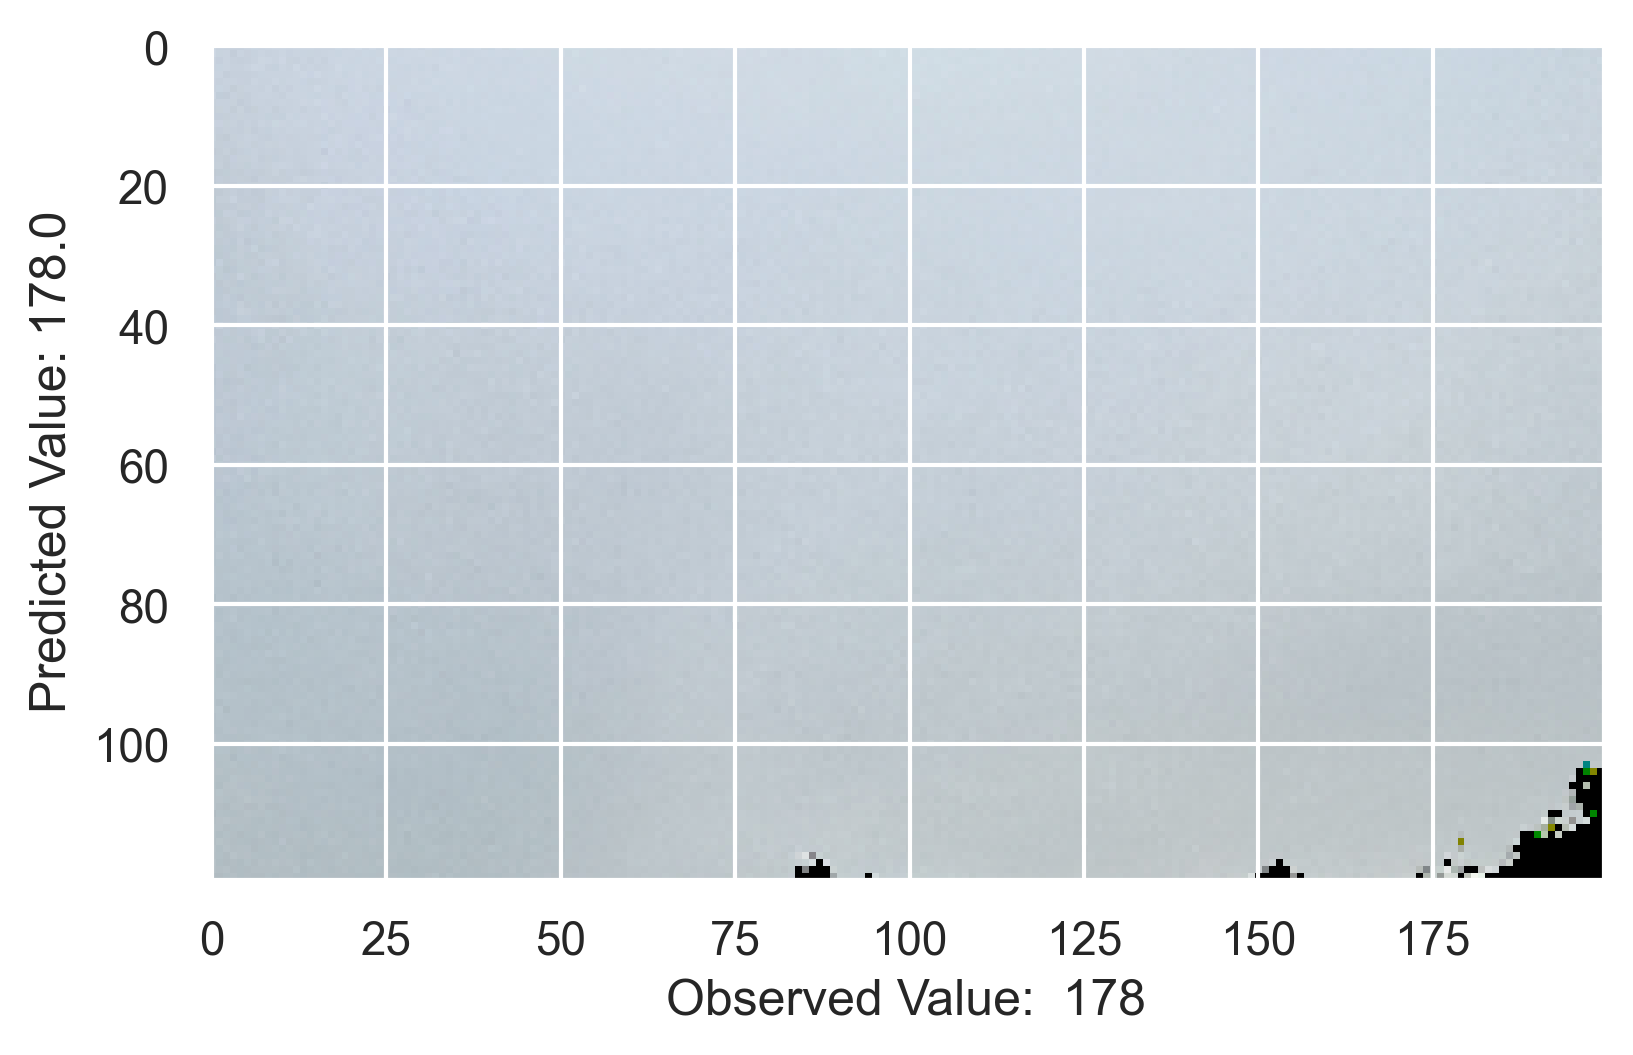

In [99]:
from PIL import Image as im

val = 72
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

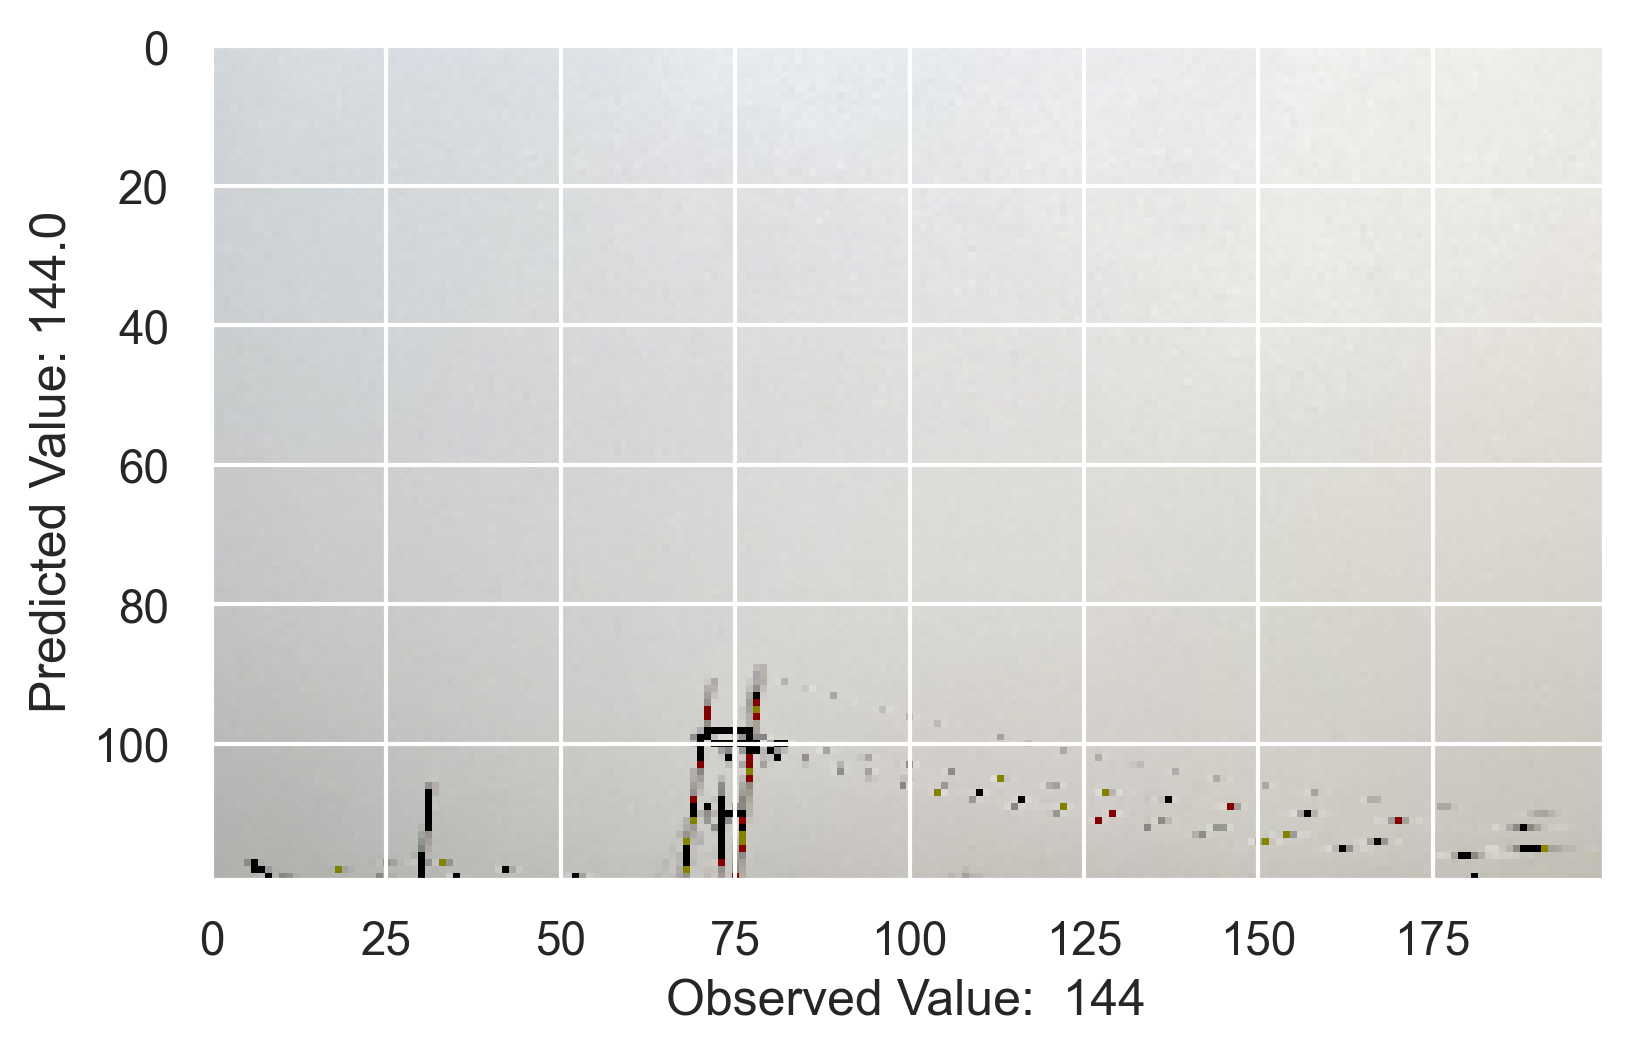

In [100]:
from PIL import Image as im

val = 172
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])

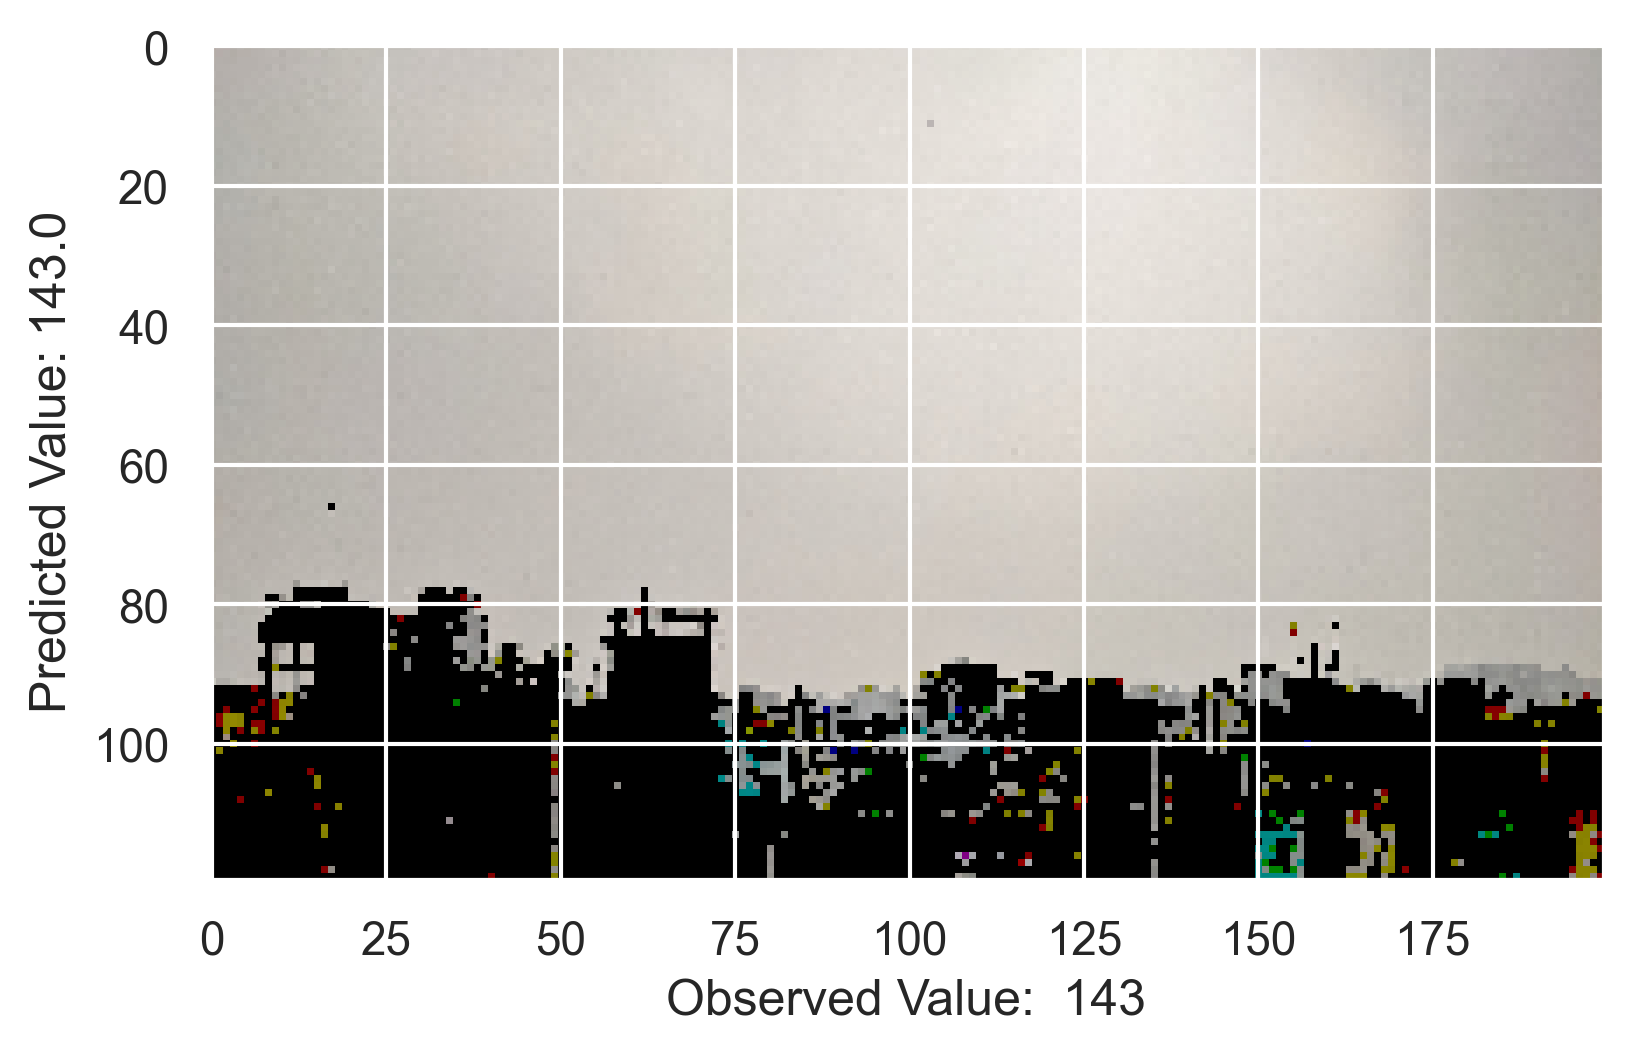

In [101]:
from PIL import Image as im

val = 181
  
data = im.fromarray((x_test[val]* 255).astype(np.uint8))
plt.imshow(data,cmap='binary')
actual_val = 'Observed Value:  ' + str(pred[val])
pred_val = 'Predicted Value: ' + str(y_test[val])
plt.xlabel(actual_val)
plt.ylabel(pred_val)
plt.gcf().set_dpi(300)
# print(x_test[0][0])